# Assessing the Interplay Between Natural Hazards and Political Instability on Migration Decisions in Bangladesh


##### -  Main Analysis.

## Import packages

In [1]:
# Type hinting and utility imports
from typing import Any, Dict, List, Union, Optional, Tuple
import pickle # For saving and loading serialized objects
import glob # For file path pattern matching
import os # For operating system interactions

# Data management and manipulation tools
import pandas as pd # Data manipulation with DataFrames
import numpy as np # Numerical computations
import geopandas as gpd # Geographic data processing
import pyreadstat # Read and write SPSS, Stata, and SAS files
import random # Random number generation
from collections import Counter # Counting hashable objects
from itertools import product # Cartesian product of iterables

# Machine learning tools
from sklearn.experimental import enable_iterative_imputer # Enable experimental imputer
from sklearn.impute import IterativeImputer # Multivariate imputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor # Random Forest models
from xgboost import XGBClassifier # XGBoost classifier
from sklearn import linear_model # Linear models

# Statsmodels for regressions
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Model evaluation metrics and calibration
from sklearn.metrics import confusion_matrix, average_precision_score, roc_auc_score, roc_curve, f1_score
from sklearn.calibration import CalibratedClassifierCV # For calibrating classifier probabilities
from random import randrange # Random number within a range
import shap # SHAP values for model interpretability

# Visualization tools
import matplotlib as mp # Core matplotlib library
import matplotlib.pyplot as plt # Matplotlib plotting functions
import seaborn as sns # Seaborn data visualization

# Custom functions 
import functions_transforms as fun      
import evaluate_train_combined as fun_analysis
import plotting_functions as fun_plots 

# Utility imports for function operations
import operator  # For functional operations like itemgetter
import json

/Users/maxle647/miniconda3/envs/ccm_bangladesh/lib/python3.9/site-packages/xgboost/compat.py:105: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## Define universal parameters

In [2]:
# Set seed.
random.seed(130822)

#### Instructions for replication:

Merge_data, do_regr, do_tuning and train are set to 'False' in oder to start directly with the analysis of the results. 

If you wish to do all the steps, change these parameters to 'True'. 

In [3]:
# Should data be merged? 
# Note, this is an initial step and does not need to be done once the dataset is prepared. Set to False for replication. 
merge_data = True
# Define if we want to do descriptives for DV. 
do_descr = True 
# Esimate regression models.
do_regr = True
# Tune models. 
# Note, set to False for replication.
do_tuning = False
# Should models be trained? 
# Note, this block needs to be run three times. Once for the "performance evaluation" and once for the "shap values" and finally for the "shap interaction".
# Note, to replicate the figures in the paper without retraining the models, set this to False.
train = True
train_robustness = True # Train a model excluding migration history as robustness check
# Evaluation.
do_evaluation = True

In [4]:
# Define folder structure to store results
base_folder_path = os.path.abspath(os.path.join(os.getcwd(), ".")) # You can also enter the path to your folder manually
#print('Check path:',base_folder_path) # Shows the path you are in

# Define input paths 
input_data_path = os.path.join(base_folder_path,'data')
#print('Data will be loaded from:',input_data_path) # Shows the path your data is read from

# Define results path
results_path = os.path.join(base_folder_path,'results')
results_path_ext = os.path.join(results_path, '{sub}')
#print('Results will be stored in:',results_path_ext) # Shows the path your results will be stored in

output_paths = {
    'descriptives': results_path_ext.format(sub=f'descriptives'),
    'models': results_path_ext.format(sub=f'models'),
    'predictions': results_path_ext.format(sub=f'predictions'),
    'features': results_path_ext.format(sub=f'features'),
    'evalscores': results_path_ext.format(sub=f'evalscores'),
    'regression': results_path_ext.format(sub=f'regression'),
    # Sub folders 
    'shapvals': os.path.join(results_path_ext.format(sub=f"features"), "shapvals"),
    
}

## Load, merge and prepare data

Instructions: Note that this step is skipped, when merge_data is set to 'False'.

In [5]:
if merge_data:
    df_hh, meta = pyreadstat.read_dta(os.path.join(input_data_path,'waves_v6.dta'))
    print(df_hh.head())

  hh_n  month    year  mig_month_id  internal_mig district_mig  \
0  1_1    3.0  2011.0           NaN           0.0           NA   
1  1_1   11.0  2011.0           NaN           0.0           NA   
2  1_1    2.0  2011.0           NaN           0.0           NA   
3  1_1    7.0  2011.0           NaN           0.0           NA   
4  1_1    9.0  2011.0           NaN           0.0           NA   

   international_mig country_mig  remittances_mig  mig_history  ... head_ocup  \
0                0.0          NA              0.0          0.0  ...      68.0   
1                0.0          NA              0.0          0.0  ...      68.0   
2                0.0          NA              0.0          0.0  ...      68.0   
3                0.0          NA              0.0          0.0  ...      68.0   
4                0.0          NA              0.0          0.0  ...      68.0   

  head_ocup_agg Bihari Tribal_ethn mobile radio   tv loss_flood  pol_unrest  \
0           0.0    0.0         0.0   

In [6]:
if merge_data:
    # Number of households
    print(len(df_hh.hh_n.unique()))
    print(df_hh.columns)

5503
Index(['hh_n', 'month', 'year', 'mig_month_id', 'internal_mig', 'district_mig',
       'international_mig', 'country_mig', 'remittances_mig', 'mig_history',
       'Division_Code', 'Division_Name', 'District_Code', 'District_Name',
       'Upazila', 'Upazila_Name', 'Union', 'Village', 'community_id',
       'religion', 'Muslim', 'Hindu', 'Christian', 'language', 'Bengali',
       'Urdu', 'Hindi', 'Tribal', 'Other', 'ethnicity', 'Bangali',
       'Other_ethn', 'head_sex', 'Male', 'Female', 'head_age', 'age_17_24',
       'age_25_34', 'age_35_48', 'age_49_70', 'age_71', 'head_literacy',
       'head_educ', 'prim_educ', 'sec_educ', 'ter_educ', 'no_educ',
       'mob_asset_value_own', 'machinery_value_own', 'savings', 'loans',
       'land_type', 'land_size', 'produc_harvested', 'ag_subsidy',
       'livestock_value', 'sl_benefited', 'income_rent', 'income_property',
       'income_insurance', 'income_other', 'income', 'n_houses',
       'health_fac_avail', 'health_fac_num', 'educ_fac

In [7]:
if merge_data:
    # Get year month id
    df_hh['yrmo'] = pd.to_datetime(df_hh[['year', 'month']].assign(DAY=1)).dt.strftime('%Y-%m')
    print(df_hh.head())

  hh_n  month    year  mig_month_id  internal_mig district_mig  \
0  1_1    3.0  2011.0           NaN           0.0           NA   
1  1_1   11.0  2011.0           NaN           0.0           NA   
2  1_1    2.0  2011.0           NaN           0.0           NA   
3  1_1    7.0  2011.0           NaN           0.0           NA   
4  1_1    9.0  2011.0           NaN           0.0           NA   

   international_mig country_mig  remittances_mig  mig_history  ...  \
0                0.0          NA              0.0          0.0  ...   
1                0.0          NA              0.0          0.0  ...   
2                0.0          NA              0.0          0.0  ...   
3                0.0          NA              0.0          0.0  ...   
4                0.0          NA              0.0          0.0  ...   

  head_ocup_agg Bihari Tribal_ethn mobile radio   tv loss_flood pol_unrest  \
0           0.0    0.0         0.0    1.0   0.0  1.0        0.0        0.0   
1           0.0    0

In [8]:
if merge_data:
    # Transform HH
    df_hh["hh_n"] = df_hh['hh_n'].map(lambda x: str(x)[:-2])
    df_hh["hh_n"] = df_hh["hh_n"].astype(int)
    print(len(df_hh.hh_n.unique()))

5503


In [9]:
if merge_data:
    # Sort df
    df_hh = df_hh.sort_values(by=['hh_n','year','month'])
    print(df_hh.head())

    hh_n  month    year  mig_month_id  internal_mig district_mig  \
6      1    1.0  2011.0           NaN           0.0           NA   
2      1    2.0  2011.0           NaN           0.0           NA   
0      1    3.0  2011.0           NaN           0.0           NA   
11     1    4.0  2011.0           NaN           0.0           NA   
5      1    5.0  2011.0           NaN           0.0           NA   

    international_mig country_mig  remittances_mig  mig_history  ...  \
6                 0.0          NA              0.0          0.0  ...   
2                 0.0          NA              0.0          0.0  ...   
0                 0.0          NA              0.0          0.0  ...   
11                0.0          NA              0.0          0.0  ...   
5                 0.0          NA              0.0          0.0  ...   

   head_ocup_agg Bihari Tribal_ethn mobile radio   tv loss_flood pol_unrest  \
6            0.0    0.0         0.0    1.0   0.0  1.0        0.0        0.0   


In [10]:
if merge_data:
    # Check NAs for time-invariant vars; drop households with NAs for waves
    print(len(df_hh[df_hh.head_age.isna()].hh_n.astype(int).unique()))
    print(len(df_hh[df_hh.head_sex.isna()].hh_n.astype(int).unique()))
    print(len(df_hh[df_hh.head_literacy.isna()].hh_n.astype(int).unique()))
    
    hhnas = list(np.array(df_hh[df_hh.head_age.isna()].hh_n.astype(int).unique())) + \
    list(np.array(df_hh[df_hh.head_sex.isna()].hh_n.astype(int).unique())) + \
    list(np.array(df_hh[df_hh.head_literacy.isna()].hh_n.astype(int).unique()))
    print(len(hhnas))
    
    hhnasunique = list(set(hhnas))
    print(len(hhnasunique))
    
    print(len(df_hh.hh_n.unique()) - len(hhnasunique))
    print(len(df_hh.set_index('hh_n').drop(hhnasunique,axis=0).index.unique())) 
    
    # Dropping households here
    df_hh = df_hh.set_index('hh_n').drop(hhnasunique,axis=0).reset_index()
    df_hh

0
0
0
0
0
5503
5503


In [11]:
if merge_data:
    # Check if for any of the values we have only missingnes
    ffillcols = [
            'mob_asset_value_own', 'machinery_value_own', 'savings', 'loans',
               'land_type', 'land_size', 'produc_harvested', 'ag_subsidy',
               'livestock_value', 'sl_benefited', 'income_rent', 'income_property',
               'income_insurance', 'income_other', 'income', 'n_houses', 'pc_expm',
               'head_ocup_agg',
               'health_fac_avail', 'health_fac_num', 'educ_fac_avail', 'educ_fac_num',
               'safety_prog_benef','remittances_in', 'remittances_in_value',
               'active_member', 'active_leader', 'satisfied_relat', 'satisfied_leave',
               'satisfied_life',
        ]
    
    for f in ffillcols:
        if df_hh[f].isnull().all():
            print('information for all rows in column is missing')

In [12]:
if merge_data:
    # Drop columns for the moment due to missingness and some of them are on the district level
    dropcols = [
        'n_houses',
        'health_fac_avail', 
        'health_fac_num', 
        'educ_fac_avail', 
        'educ_fac_num',
        'safety_prog_benef',
    ]
    
    df_hh = df_hh.drop(dropcols,axis=1)
    print(len(df_hh.hh_n.unique()))

5503


In [13]:
# Code outcome
if merge_data:
        df_hh['both_out'] = df_hh.international_mig + df_hh.internal_mig # As they are either or

In [14]:
if merge_data:
    # Check data
    df = df_hh.copy()
    print(df.head())

   hh_n  month    year  mig_month_id  internal_mig district_mig  \
0     1    1.0  2011.0           NaN           0.0           NA   
1     1    2.0  2011.0           NaN           0.0           NA   
2     1    3.0  2011.0           NaN           0.0           NA   
3     1    4.0  2011.0           NaN           0.0           NA   
4     1    5.0  2011.0           NaN           0.0           NA   

   international_mig country_mig  remittances_mig  mig_history  ... Bihari  \
0                0.0          NA              0.0          0.0  ...    0.0   
1                0.0          NA              0.0          0.0  ...    0.0   
2                0.0          NA              0.0          0.0  ...    0.0   
3                0.0          NA              0.0          0.0  ...    0.0   
4                0.0          NA              0.0          0.0  ...    0.0   

  Tribal_ethn mobile radio   tv loss_flood pol_unrest incr_food_prices  \
0         0.0    1.0   0.0  1.0        0.0        0.0 

#### Merge with external data

##### Nightlight data on upazila level

In [15]:
if merge_data:
    df_ngt = pd.read_csv(os.path.join(input_data_path,'newupazilawlight.csv'), delimiter=',')
    df_ngt.head()

In [16]:
if merge_data:
    # Rename columns
    for i in range(11,19):
        df_ngt = df_ngt.rename(columns={f'lights{i}':2000+i})
    print(df_ngt.head())

   Unnamed: 0  ID_0  ISO      NAME_0  ID_1   NAME_1  ID_2   NAME_2  ID_3  \
0           0    19  BGD  Bangladesh     1  Barisal     1  Barisal     1   
1           1    19  BGD  Bangladesh     1  Barisal     1  Barisal     1   
2           2    19  BGD  Bangladesh     1  Barisal     1  Barisal     1   
3           3    19  BGD  Bangladesh     1  Barisal     1  Barisal     1   
4           4    19  BGD  Bangladesh     1  Barisal     1  Barisal     1   

    NAME_3  ...     ENGTYPE_4      2011      2012      2013      2014  \
0  Barisal  ...  Sub-district  0.612245  0.567010  0.304124  4.989691   
1  Barisal  ...  Sub-district  2.478873  2.869767  2.162791  4.669767   
2  Barisal  ...  Sub-district  0.305804  0.143177  0.129754  2.975391   
3  Barisal  ...  Sub-district  0.839506  1.245283  0.534591  4.100629   
4  Barisal  ...  Sub-district  7.668874  8.750000  8.694079  9.072368   

       2015      2016       2017       2018  \
0  5.608247  4.427835   7.025773   7.036082   
1  6.24651

In [17]:
if merge_data:
    # Reshape df
    cols_ngt = ['NAME_4',2011,2012,2013,2014,2015,2016,2017,2018]
    df_ngt = df_ngt[cols_ngt].set_index('NAME_4').stack()
    # Rename
    df_ngt = df_ngt.rename('nlight_mean')
    df_ngt = df_ngt.reset_index().rename(columns={'level_1':'year'})
    print(df_ngt.head())

       NAME_4  year  nlight_mean
0  Agailjhara  2011     0.612245
1  Agailjhara  2012     0.567010
2  Agailjhara  2013     0.304124
3  Agailjhara  2014     4.989691
4  Agailjhara  2015     5.608247


In [18]:
if merge_data:
    # Fix names
    df_hh.Upazila_Name = df_hh.Upazila_Name.str.replace('Baghai Chhari','Baghaichhari')
    df_hh.Upazila_Name = df_hh.Upazila_Name.str.replace('Sadar','S.')

In [19]:
if merge_data:
    # Rename upazilas based on df_hh
    print(set(df_hh.Upazila_Name.unique()) - set(df_ngt.NAME_4.unique()))
    print(set(df_ngt.NAME_4.unique()) - set(df_hh.Upazila_Name.unique()))
    print(len(df_ngt.NAME_4.unique()))
    print(len(df_hh.Upazila_Name.unique()))

{'Shib Char', 'Shajahanpur', 'Palong', 'Chakoria', 'Banchharampur', 'Baghaichhari', 'Maulvibazar Sada', 'Fulchhari', 'Mohanganj Thana', 'Char Rajibpur', 'Sarankhola', 'Char Fasson', 'Kalukhali', 'Jiban Nagar', 'Austagram', 'Noakhali S. (Sudh', "Cox'S Bazar S.", 'Maheshpur Upazil', 'Sulla', 'Brahmanbaria Sad', 'Haim Char', 'Palash Paurashava', 'Daulat Khan', 'Beani Bazar', 'Fulbaria', 'Barisal S. (Kotwa', 'Golapganj', 'Comilla S. (Kotwa', 'Roypura', 'Kaliganj Upazila', 'Mahadebpur', 'Kuliar Char', 'Harinakundu Upaz', 'Dhanbari', 'Mitha Pukur', 'Bakshiganj', 'Roypur', 'Kaligang', 'Raumari', 'Ashuganj', 'S.pur', 'Kendua Thana', 'Maulvi Bazar S.', 'Royganj', 'Comilla Adarsha', 'Kanthalia', 'Titas', "Cox's Bazar Sada"}
{'Dashina', 'Bochaganj', 'Paba', 'Anwara', 'Bagha', 'Chandanaish', 'Baksiganj', 'Kuliarchar', 'Tejgaon', 'Chhagalnaiya', 'Bagatipara', 'Daulatkhan', 'Gaurnadi', 'Bholahat', 'Sapahar', 'Jagannathpur', 'Gaibandha S.', 'Cox Bazar S', 'Madan', 'Durgapur', 'Kalai', 'Panchagarh S.'

In [20]:
if merge_data:
    # Rename all apart from Nasirabad, Parbattya Chattagram
    df_hh.Upazila_Name = df_hh.Upazila_Name.replace({
        'Maheshpur Upazil':'Maheshpur', 
        'Bakshiganj':'Baksiganj',
        'Noakhali S. (Sudh':'Noakhali S.', 
        'Palash Paurashava':'Palash',
        'Roypura':'Shibpur',
        'Raumari':'Raomari', 
        'Barisal S. (Kotwa':'Barisal S.', 
        'Baghaichhari':'Bagaichhari', 
        'Char Rajibpur':'Charrajibpur', 
        'Kaligang':'Kaliganj', 
        'Sarankhola':'Morrelganj', 
        'Haim Char':'Haimchar',
        'Sulla':'Sullah', 
        'Daulat Khan':'Daulatkhan',
        'Comilla S. (Kotwa':'Comilla S.', 
        'Dhanbari':'Madhupur',
        'Fulchhari':'Gaibandha S.', 
        'Kalukhali':'Kawkhali', 
        'Banchharampur':'Bancharampur', 
        'Comilla Adarsha':'Comilla S.', 
        'Kendua Thana':'Kendua', 
        'Kuliar Char':'Kuliarchar', 
        'Maulvibazar Sada':'Maulvibazar S.', 
        'Banari Para':'Banaripara', 
        "Cox's Bazar Sada":'Cox Bazar S', 
        'Mohanganj Thana':'Mohanganj', 
        'Austagram':'Astagram', 
        'Titas':'Faridpur', 
        'S.pur':'Sadarpur', 
        'Kanthalia':'Kathalia', 
        'Shib Char':'Shibchar', 
        'Royganj':'Raiganj', 
        'Harinakundu Upaz':'Harinakunda', 
        'Shajahanpur':'Shahjadpur', 
        'Golapganj':'Gopalganj S.', 
        'Beani Bazar':'Beanibazar', 
        'Maulvi Bazar S.':'Maulvibazar S.', 
        'Palong':'Shariatpur S.', 
        'Fulbaria':'Trishal', 
        'Naria':'Sakhipur', 
        'Roypur':'Raipur', 
        'Bagher Para':'Bagherpara', 
        'Kaliganj Upazila':'Kaliganj', 
        'Mitha Pukur':'Mithapukur', 
        'Mahadebpur':'Mahadevpur', 
        'Char Fasson':'Charfasson', 
        'Ashuganj':'Amtali', 
        'Brahmanbaria Sad':'Brahmanbaria S.', 
        "Cox'S Bazar S.":'Cox Bazar S', 
        'Jiban Nagar':'Jibannagar', 
        'Chakoria':'Chakaria',    
    })

In [21]:
if merge_data:
    print(set(df_hh.Upazila_Name.unique()) - set(df_ngt.NAME_4.unique()))

set()


In [22]:
if merge_data:
    df_ngt = df_ngt.set_index(['NAME_4','year'])
    df_ngt = df_ngt[~df_ngt.index.duplicated(keep='first')]
    print('Has Duplicates:',df_ngt.index.has_duplicates)

Has Duplicates: False


In [23]:
if merge_data:
    df_ngt = df_ngt.reset_index(['NAME_4','year'])

In [24]:
if merge_data:
    # Merge
    df_m = df_hh.merge(df_ngt,how='left',left_on=['Upazila_Name', 'year'], right_on=['NAME_4', 'year'])
    print('Numbers of rows after join equals number of rows before join:', len(df_hh) == len(df_m))
    print(df_m.head())

Numbers of rows after join equals number of rows before join: True
   hh_n  month    year  mig_month_id  internal_mig district_mig  \
0     1    1.0  2011.0           NaN           0.0           NA   
1     1    2.0  2011.0           NaN           0.0           NA   
2     1    3.0  2011.0           NaN           0.0           NA   
3     1    4.0  2011.0           NaN           0.0           NA   
4     1    5.0  2011.0           NaN           0.0           NA   

   international_mig country_mig  remittances_mig  mig_history  ... mobile  \
0                0.0          NA              0.0          0.0  ...    1.0   
1                0.0          NA              0.0          0.0  ...    1.0   
2                0.0          NA              0.0          0.0  ...    1.0   
3                0.0          NA              0.0          0.0  ...    1.0   
4                0.0          NA              0.0          0.0  ...    1.0   

  radio   tv loss_flood pol_unrest incr_food_prices     yrmo 

In [25]:
if merge_data:
    # Extrapolate
    df_m = df_m.set_index(['hh_n','yrmo'])
    df_m['nlight_mean'] = fun.extrapolate(df=df_m['nlight_mean'],grouplevel=0)
    df_m = df_m.reset_index()
    print(df_m[df_m['nlight_mean'].isna()])

Empty DataFrame
Columns: [hh_n, yrmo, month, year, mig_month_id, internal_mig, district_mig, international_mig, country_mig, remittances_mig, mig_history, Division_Code, Division_Name, District_Code, District_Name, Upazila, Upazila_Name, Union, Village, community_id, religion, Muslim, Hindu, Christian, language, Bengali, Urdu, Hindi, Tribal, Other, ethnicity, Bangali, Other_ethn, head_sex, Male, Female, head_age, age_17_24, age_25_34, age_35_48, age_49_70, age_71, head_literacy, head_educ, prim_educ, sec_educ, ter_educ, no_educ, mob_asset_value_own, machinery_value_own, savings, loans, land_type, land_size, produc_harvested, ag_subsidy, livestock_value, sl_benefited, income_rent, income_property, income_insurance, income_other, income, remittances_in, remittances_in_value, active_member, active_leader, satisfied_relat, satisfied_leave, satisfied_life, hhweight, popweight, pc_expm, pc_foodxm, pc_nonfxm, head_ocup, head_ocup_agg, Bihari, Tribal_ethn, mobile, radio, tv, loss_flood, pol_un

##### Other external data

In [26]:
if merge_data:
    # Load external dfs
    df_ext = pd.read_csv(os.path.join(input_data_path,'external_district_Nov29_df.csv.zip'), compression='zip', header=0)
    print(df_ext)

        NAME_2     yrmo  year  ID_2  PG_GCP_PPP_LI  \
0      Barisal  1989-01  1989     1       0.000000   
1      Barisal  1989-02  1989     1       0.000000   
2      Barisal  1989-03  1989     1       0.000000   
3      Barisal  1989-04  1989     1       0.000000   
4      Barisal  1989-05  1989     1       0.000000   
...        ...      ...   ...   ...            ...   
23803   Sylhet  2019-08  2019    64       1.808422   
23804   Sylhet  2019-09  2019    64       1.808422   
23805   Sylhet  2019-10  2019    64       1.808422   
23806   Sylhet  2019-11  2019    64       1.808422   
23807   Sylhet  2019-12  2019    64       1.808422   

                                                geometry  gdis_n_disasters  \
0      MULTIPOLYGON (((90.43000031 22.49504471, 90.43...               0.0   
1      MULTIPOLYGON (((90.43000031 22.49504471, 90.43...               0.0   
2      MULTIPOLYGON (((90.43000031 22.49504471, 90.43...               0.0   
3      MULTIPOLYGON (((90.43000031 22.4

In [27]:
if merge_data:
    # Check for NAs
    for col in df_ext.columns:
        if df_ext[f'{col}'].isna().any() == True:
            print(col)

In [28]:
if merge_data:
    print(set(df_m.District_Name.unique()) - set(df_ext.NAME_2.unique()))
    print(set(df_ext.NAME_2.unique()) - set(df_m.District_Name.unique()))

{"Cox's Bazar", 'Brahmanbaria', 'Chapai Nawabganj', 'Jhenaidah Zila T', 'Kishorgonj'}
{'Brahamanbaria'}


In [29]:
if merge_data:
    # Rename admin 2 based on x_sub
    print(set(df_m.District_Name.unique()) - set(df_ext.NAME_2.unique()))
    
    df_m['District_Name'] = df_m['District_Name'].replace({
        'Chapai Nawabganj':'Nawabganj',
        'Brahmanbaria':'Brahamanbaria',
        "Cox's Bazar":"Cox'S Bazar",
        'Jhenaidah Zila T':'Jhenaidah',
        'Kishorgonj':'Kishoreganj',
        
    })
    
    print('No differences:', set(df_m.District_Name.unique()) == set(df_ext.NAME_2.unique()))

{"Cox's Bazar", 'Brahmanbaria', 'Chapai Nawabganj', 'Jhenaidah Zila T', 'Kishorgonj'}
No differences: True


In [30]:
if merge_data:
    # Transform spei to more intuitive scale
    df_ext['spei_3_tlag12'] = df_ext['spei_3_tlag12']*(-1)
    df_ext['spei_3'] = df_ext['spei_3']*(-1)
    df_ext['spei_6_tlag12'] = df_ext['spei_6_tlag12']*(-1)
    df_ext['spei_6'] = df_ext['spei_6']*(-1)
    df_ext['spei_12_tlag12'] = df_ext['spei_12_tlag12']*(-1)
    df_ext['spei_12'] = df_ext['spei_12']*(-1)

    # Add dummies
    df_ext["spei_3_tlag12_severe"]  = (df_ext["spei_3_tlag12"] > 1.5).astype(int)
    df_ext["spei_3_tlag12_extreme"] = (df_ext["spei_3_tlag12"] > 2.0).astype(int)
    df_ext["spei_3_severe"]  = (df_ext["spei_3"] > 1.5).astype(int)
    df_ext["spei_3_extreme"] = (df_ext["spei_3"] > 2.0).astype(int)

    # Add additional transformations for spei varialbes
    df_ext = df_ext.sort_values(["NAME_2", "yrmo"])
    
    for col in ["spei_3_severe", "spei_3_extreme"]:
        df_ext[f"{col}_ts_decay_6"] = (
            df_ext.groupby("NAME_2", sort=False)[col]
              .transform(lambda s: fun.decay(fun.time_since_last_event(s), halflife=6))
              .astype(float)
        )
        # 12-month lag
        df_ext[f"{col}_ts_decay_6_tlag12"] = (
            df_ext.groupby("NAME_2", sort=False)[f'{col}_ts_decay_6'].shift(12)
        )
    

In [31]:
if merge_data:
    # Filter years
    df_ext = df_ext[df_ext.year>2009]

In [32]:
if merge_data:
    # Merge
    df = df_m.merge(df_ext,how='left',left_on=['District_Name', 'yrmo'], right_on=['NAME_2', 'yrmo'])
    
    print('Numbers of rows after join equals number of rows before join:', len(df_hh) == len(df_m))

Numbers of rows after join equals number of rows before join: True


In [33]:
if merge_data:
    # Check if merge successful
    print(df[df.year_y != df.year_x])
    df = df.drop(columns=['year_x'])
    df = df.rename(columns={'year_y':'year'})

Empty DataFrame
Columns: [hh_n, yrmo, month, year_x, mig_month_id, internal_mig, district_mig, international_mig, country_mig, remittances_mig, mig_history, Division_Code, Division_Name, District_Code, District_Name, Upazila, Upazila_Name, Union, Village, community_id, religion, Muslim, Hindu, Christian, language, Bengali, Urdu, Hindi, Tribal, Other, ethnicity, Bangali, Other_ethn, head_sex, Male, Female, head_age, age_17_24, age_25_34, age_35_48, age_49_70, age_71, head_literacy, head_educ, prim_educ, sec_educ, ter_educ, no_educ, mob_asset_value_own, machinery_value_own, savings, loans, land_type, land_size, produc_harvested, ag_subsidy, livestock_value, sl_benefited, income_rent, income_property, income_insurance, income_other, income, remittances_in, remittances_in_value, active_member, active_leader, satisfied_relat, satisfied_leave, satisfied_life, hhweight, popweight, pc_expm, pc_foodxm, pc_nonfxm, head_ocup, head_ocup_agg, Bihari, Tribal_ethn, mobile, radio, tv, loss_flood, pol_

#### Prepare data

In [34]:
if merge_data:
    # Summarize shape
    print(df.shape)
    
    # Show first few rows
    print(df.head())

(594324, 1069)
   hh_n     yrmo  month  mig_month_id  internal_mig district_mig  \
0     1  2011-01    1.0           NaN           0.0           NA   
1     1  2011-02    2.0           NaN           0.0           NA   
2     1  2011-03    3.0           NaN           0.0           NA   
3     1  2011-04    4.0           NaN           0.0           NA   
4     1  2011-05    5.0           NaN           0.0           NA   

   international_mig country_mig  remittances_mig  mig_history  ...  \
0                0.0          NA              0.0          0.0  ...   
1                0.0          NA              0.0          0.0  ...   
2                0.0          NA              0.0          0.0  ...   
3                0.0          NA              0.0          0.0  ...   
4                0.0          NA              0.0          0.0  ...   

  spei_12_tlag6 spei_12_tlag12 spei_3_tlag12_severe spei_3_tlag12_extreme  \
0      0.188981       0.066370                    0                     

In [35]:
if merge_data:
    # Make unique monthid and set index
    df = df.set_index(['yrmo','hh_n'])
    month_id = list(range(1,len(df.index.get_level_values(0).unique())+1))
    df.index = df.index.set_levels(month_id, level='yrmo')
    
    df = df.sort_index(level=0).reset_index()
    print(df.head())

   yrmo  hh_n  month  mig_month_id  internal_mig district_mig  \
0     1     1    1.0           NaN           0.0           NA   
1     1     2    1.0           NaN           0.0           NA   
2     1     3    1.0           NaN           0.0           NA   
3     1     4    1.0           NaN           0.0           NA   
4     1     5    1.0           NaN           0.0           NA   

   international_mig country_mig  remittances_mig  mig_history  ...  \
0                0.0          NA              0.0          0.0  ...   
1                0.0          NA              0.0          0.0  ...   
2                0.0          NA              0.0          0.0  ...   
3                0.0          NA              0.0          0.0  ...   
4                0.0          NA              0.0          0.0  ...   

  spei_12_tlag6 spei_12_tlag12 spei_3_tlag12_severe spei_3_tlag12_extreme  \
0      0.188981        0.06637                    0                     0   
1      0.188981        0.066

In [36]:
if merge_data:
    # Add string for plotting
    df["date_str"] = df.year.astype(int).astype(str) + "-" + df.month.astype(int).astype(str)

      internal_mig  international_mig  year
yrmo                                       
89            30.0                4.0  2018
90            27.0                4.0  2018
91            28.0               10.0  2018
92            39.0               11.0  2018
93            45.0                6.0  2018
94            29.0               10.0  2018
95            27.0                7.0  2018
96            24.0                9.0  2018
97            31.0                7.0  2019
98            22.0                2.0  2019
99             1.0                1.0  2019
100            1.0                0.0  2019
101            0.0                0.0  2019
102            0.0                0.0  2019
103            0.0                0.0  2019
104            0.0                0.0  2019
105            0.0                0.0  2019
106            0.0                0.0  2019
107            0.0                0.0  2019
108            0.0                0.0  2019


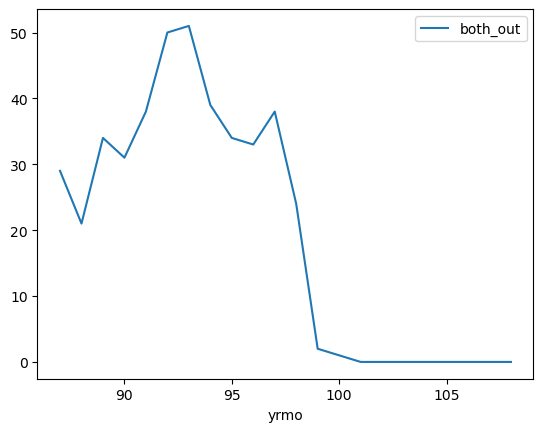

In [37]:
if merge_data:
    # Check where to cut off end months
    print(df.groupby('yrmo').aggregate({'internal_mig':'sum','international_mig':'sum','year':'first'}).loc[89:])
    df.groupby('yrmo').aggregate({'both_out':'sum'}).loc[87:].plot() 

In [38]:
if merge_data:
    # Filter years (December 2018)
    df = df.set_index(['yrmo','hh_n']).loc[:96,:].reset_index()
    print(df.head())
    print(df.tail())

   yrmo  hh_n  month  mig_month_id  internal_mig district_mig  \
0     1     1    1.0           NaN           0.0           NA   
1     1     2    1.0           NaN           0.0           NA   
2     1     3    1.0           NaN           0.0           NA   
3     1     4    1.0           NaN           0.0           NA   
4     1     5    1.0           NaN           0.0           NA   

   international_mig country_mig  remittances_mig  mig_history  ...  \
0                0.0          NA              0.0          0.0  ...   
1                0.0          NA              0.0          0.0  ...   
2                0.0          NA              0.0          0.0  ...   
3                0.0          NA              0.0          0.0  ...   
4                0.0          NA              0.0          0.0  ...   

  spei_12_tlag12 spei_3_tlag12_severe spei_3_tlag12_extreme spei_3_severe  \
0        0.06637                    0                     0             0   
1        0.06637            

#### Apply additional transformations

In [39]:
if merge_data:
    # LN income variables
    colshh = [
        'mob_asset_value_own',
        'machinery_value_own',
        'savings',
        'loans',
        'land_size',
        'pc_expm',
        'produc_harvested',
        'livestock_value',
        'income',
        'remittances_in_value',
    ]
    
    for col in colshh:
        df[f'ln_{col}'] = fun.ln(df[f'{col}'])

In [40]:
if merge_data:
    # Lag income variables
    df = df.set_index(['hh_n', 'yrmo'])
    
    for var in [
        'ln_mob_asset_value_own',
        'ln_machinery_value_own',
        'ln_savings',
        'ln_loans',
        'ln_land_size',
        'ln_pc_expm',
        #'ln_produc_harvested', - land size correlation
        'ag_subsidy',
        'ln_livestock_value',
        'sl_benefited',
        'ln_income',
        'ln_remittances_in_value',
        'mobile', 'radio', 'tv'
    ]:
        print('lagging', var)
        df[f'{var}_tlag12'] = df.groupby(level=0)[f'{var}'].shift(12)
        
    df = df.reset_index()
    df.columns

lagging ln_mob_asset_value_own
lagging ln_machinery_value_own
lagging ln_savings
lagging ln_loans
lagging ln_land_size
lagging ln_pc_expm
lagging ag_subsidy
lagging ln_livestock_value
lagging sl_benefited
lagging ln_income
lagging ln_remittances_in_value
lagging mobile
lagging radio
lagging tv


In [42]:
if merge_data:
    # Only save columns/variables that are used
    save_cols = [
        'NAME_2',
        'District_Name',
        'Division_Name',
        'year',
        'hh_n',
        'yrmo',
        'internal_mig',
        'international_mig',
        'both_out',
        'date_str',
        'head_age',
        'head_sex',
        'prim_educ',
        'sec_educ',
        'ter_educ',
        'no_educ',
        'religion',
        'ethnicity',
        'mig_history',
        'mobile',
        'radio',
        'tv',
        'head_age',
        'head_sex',
        # education of hh
        'prim_educ',
        'sec_educ',
        'ter_educ',
        'no_educ',
        'religion',
        'ethnicity',
        'head_ocup_agg',
        # Migration history
        'mig_history',
        # Forms of income
        'ln_mob_asset_value_own',
        'ln_savings',
        'ln_loans',
        'ln_land_size',
        'ln_pc_expm',
        'ag_subsidy',
        'ln_livestock_value',
        'sl_benefited',
        'ln_income',
        'ln_remittances_in_value',
        'mob_asset_value_own', # Non-logged versions
        'savings',
        'loans',
        'land_size',
        'pc_expm',
        'livestock_value',
        'income',
        'remittances_in_value',
        # Additional
        'active_member',
        'active_leader',
        'satisfied_leave',
        'satisfied_life',
        'mobile',
        'radio',
        'tv',
        'nlight_mean',
        'PG_GCP_PPP_LI',
        'ged_best_ns_tlag12',
        'ged_best_sb_tlag12',
        'ged_best_osv_tlag12',
        'ged_best_ns_splag1_tlag12',
        'ged_best_sb_splag1_tlag12',
        'ged_best_osv_splag1_tlag12',
        'acled_prrio_count_tlag12',
        'acled_prrio_count_splag1_tlag12',
        'acled_prex_count_tlag12',
        'acled_prex_count_splag1_tlag12',
        'ged_best_ns_ts_decay_6_tlag12',
        'ged_best_osv_ts_decay_6_tlag12',
        'ged_best_sb_ts_decay_6_tlag12',
        'acled_prrio_count_ts_decay_6_tlag12',
        'acled_prrio_count_splag1_ts_decay_6_tlag12',
        'acled_prex_count_ts_decay_6_tlag12',
        'acled_prex_count_splag1_ts_decay_6_tlag12',
        'deco_best_ns_tlag12',
        'deco_best_sb_tlag12',
        'deco_best_osv_tlag12',
        'deco_best_ns_splag1_tlag12',
        'deco_best_sb_splag1_tlag12',
        'deco_best_osv_splag1_tlag12',
        'deco_best_ns_ts_decay_6_tlag12',
        'deco_best_osv_ts_decay_6_tlag12',
        'deco_best_sb_ts_decay_6_tlag12',
        'gdis_n_disasters_tlag12',
        'flood_dummy_ts_decay_6_tlag12',
        'gdis_disastertype_flood_ts_decay_6_tlag12',
        'gdis_disastertype_landslide_ts_decay_6_tlag12',
        'gdis_disastertype_storm_ts_decay_6_tlag12',
        'gdis_disastertype_earthquake_ts_decay_6_tlag12',
        'spei_3_tlag12',
        'spei_3_severe_ts_decay_6_tlag12',
        'spei_3_extreme_ts_decay_6_tlag12',
        'gdis_disastertype_landslide_tlag12',
        'gdis_disastertype_storm_tlag12',
        'gdis_disastertype_earthquake_tlag12',
        'gdis_disastertype_flood_tlag12',
        'acled_prex_count_msum_12_tlag12', 'acled_prrio_count_msum_12_tlag12', 'acled_prrio_count_splag1_msum_12_tlag12', 'deco_best_ns_msum_12_tlag12', 'deco_best_ns_splag1_msum_12_tlag12', 'deco_best_ns_splag1_ts_decay_6_tlag12', 'deco_best_osv_msum_12_tlag12', 'deco_best_osv_splag1_msum_12_tlag12', 'deco_best_osv_splag1_ts_decay_6_tlag12', 'deco_best_sb_msum_12_tlag12', 'deco_best_sb_splag1_msum_12_tlag12', 'deco_best_sb_splag1_ts_decay_6_tlag12', 'gdis_disastertype_earthquake_msum_12_tlag12', 'gdis_disastertype_flood_msum_12_tlag12', 'gdis_disastertype_landslide_msum_12_tlag12', 'gdis_disastertype_storm_msum_12_tlag12', 'ged_best_ns_msum_12_tlag12', 'ged_best_ns_splag1_msum_12_tlag12', 'ged_best_ns_splag1_ts_decay_6_tlag12', 'ged_best_osv_msum_12_tlag12', 'ged_best_osv_splag1_msum_12_tlag12', 'ged_best_osv_splag1_ts_decay_6_tlag12', 'ged_best_sb_msum_12_tlag12', 'ged_best_sb_splag1_msum_12_tlag12', 'ged_best_sb_splag1_ts_decay_6_tlag12', 'language'
    ]

    # Make sure there are no duplicates
    save_cols_unique = list(set(save_cols))    

    df[save_cols_unique].to_csv(os.path.join(input_data_path,'merged_df_ncc.csv'),index=False)


## Descriptives: DV

In [ ]:
# Load data
if do_descr:
    
    df = pd.read_csv(os.path.join(input_data_path,'merged_df_ncc.csv'))
    print(df.head())

In [ ]:
if do_descr:
    
    print(df.year.min(),df.year.max())

In [ ]:
if do_descr:
    cols = ["international_mig", "internal_mig"]
    
    # Collapse to household level 
    g = df.groupby("hh_n")[cols].sum().fillna(0)
    intl   = g["international_mig"] > 0
    inter  = g["internal_mig"] > 0
    
    # Shares (can overlap)
    share_intl  = intl.mean() # share of HH with any international migration
    share_inter = inter.mean() # share of HH with any internal migration
    
    # Exclusive breakdown 
    share_intl_only  = (intl & ~inter).mean()
    share_inter_only = (~intl & inter).mean()
    share_both       = (intl & inter).mean()
    share_none       = (~(intl | inter)).mean()
    
    # Any migration
    share_any = (intl | inter).mean()
    
    # Counts
    n_hh   = len(g)
    counts = {
        "intl": int(intl.sum()),
        "inter": int(inter.sum()),
        "intl_only": int((intl & ~inter).sum()),
        "inter_only": int((~intl & inter).sum()),
        "both": int((intl & inter).sum()),
        "none": int((~(intl | inter)).sum()),
        "any": int((intl | inter).sum()),
        "total_households": n_hh,
    }
    
    print(f"Share intl:  {share_intl:.1%}")
    print(f"Share internal: {share_inter:.1%}")
    print(f"Intl only:  {share_intl_only:.1%}")
    print(f"Internal only: {share_inter_only:.1%}")
    print(f"Both: {share_both:.1%}")
    print(f"None: {share_none:.1%}")
    print(f"Any migration: {share_any:.1%}")
    print(counts)

In [ ]:
if do_descr:
    cols = ["international_mig", "internal_mig"]
    
    g = (df.groupby("hh_n")[cols]
           .sum()
           .fillna(0)
           .astype(int))
    
    total_events = g.sum(axis=1)
    
    # How many HHs had >1 migration events (of any type)?
    n_gt1_any   = int((total_events > 1).sum())
    share_gt1   = (total_events > 1).mean()
    n_hh        = len(g)
    
    print(f">1 events (any type): {n_gt1_any} / {n_hh} ({share_gt1:.1%})")

In [ ]:
# TABLE S3 Appendix:
if do_descr:
    def make_migration_category(row): # Make category for table S3 in Appendix
        if row['international_mig'] == 1:
            return "international movements"
        elif row['internal_mig'] == 1:
            return "internal movements"
        else:
            return "immobility"
    
    df['migration_all'] = df.apply(make_migration_category, axis=1)
    
    counts = df['migration_all'].value_counts()
    percentages = df['migration_all'].value_counts(normalize=True) * 100
    
    df_descr = pd.DataFrame({
        "Categories": counts.index,
        "Counts": counts.values,
        "Percentage": percentages.round(2).values
    })
    
    # Add total row
    df_descr.loc[len(df_descr)] = ["total", counts.sum(), 100.00]

    # Save csv
    df_descr.to_csv(os.path.join(output_paths['descriptives'],
                                 f"SI_tabs3_summary_stats_both_out_fulldf.csv"),
                    index=False)

    # Save tex
    tex = df_descr.to_latex(index=False)
    with open(os.path.join(output_paths['descriptives'],
                           f"SI_tabs3_summary_stats_both_out_fulldf.tex"), "w") as f:
        f.write(tex)

    print(f"Wrote scores table to {output_paths['descriptives']}")
    print(df_descr)

In [ ]:
# TABLE S4 Appendix:
if do_descr:
    events_per_year = (
        df.groupby('year')[['international_mig', 'internal_mig']]
          .sum()
          .assign(any=lambda d: d['international_mig'] + d['internal_mig'])
    ).reset_index()

    # 
    events_per_year['Household Share'] = (events_per_year['any'].div(5503))*100
    events_per_year[['international_mig','internal_mig','any']]= events_per_year[['international_mig','internal_mig','any']].astype(int)

    # Rename
    events_per_year = events_per_year.rename(columns={
        "year": "Year",
        "international_mig": "Households (HH) w. international migration",
        "internal_mig": "HH w. internal migration",
        "any": "HH w. any migration",
        "Household Share": "Share of HH w. any migration"
    }).round(2)

    # Save tex
    tex = events_per_year.to_latex(index=False)
    with open(os.path.join(output_paths['descriptives'],
                           f"SI_tabs4_summary_stats_yearly.tex"), "w") as f:
        f.write(tex)

    print(f"Wrote scores table to {output_paths['descriptives']}")
    print(events_per_year)

    

In [ ]:
# TABLE S5 Appendix:
if do_descr:
    
    # Count households per district
    district_counts = df.groupby('District_Name')['both_out'].sum().reset_index()
    district_counts = district_counts.rename(columns={'both_out': 'Households'})

    # Add percentage
    total = district_counts['Households'].sum()
    district_counts['Share (%)'] = (district_counts['Households'] / total * 100).round(2)

    # Sort for readability (optional)
    district_counts = district_counts.sort_values('Households', ascending=False)

    # Export LaTeX table
    tex = district_counts.to_latex(
        index=False,
        caption="Number and percentage of surveyed households by district.",
        label="tab:district_distribution",
        longtable=False
    )

    with open(os.path.join(output_paths['descriptives'], "SI_tabs5_district_distribution.tex"), "w") as f:
        f.write(tex)

    print(district_counts)


In [ ]:
if do_descr:

    # Households per month that migrated
    fig_scale=1
    save_fig = False
    name = 'both_outcomes'

    # Set up figure space.
    fig = plt.figure(figsize=(20 * fig_scale, 7.5 * fig_scale))
    ax = fig.add_subplot(111)

    # Set up y-axis lim.
    #plt.ylim([ymin, ymax])
    

    # Format grid lines.
    ax.grid(
        which="major",
        axis="y",
        linestyle="--",
        dashes=(2, 3),
        lw=1,
        color="black",
        alpha=0.2,
    )

    # Remove plot framelines.
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    labels = [item for item in ax.get_xticklabels()]

    ax.set_xticks(df.reset_index().groupby('yrmo').aggregate({'both_out':'sum','date_str':'first'}).index[::4])
    ax.set_xticklabels(df.reset_index().groupby('yrmo').aggregate({'both_out':'sum','date_str':'first'}).date_str[::4])

    df.reset_index().groupby('yrmo').aggregate({'both_out':'sum','date_str':'first'}).both_out.plot(color='black')
    #df.reset_index().groupby('yrmo').aggregate({'both_out':'sum'}).both_out.plot(label='International')

    ax.set_xlabel('Year-Month')
    ax.set_ylabel('Number of migrant-sending households')
    
    plt.grid(axis = 'x', linewidth=0.5)

    if save_fig:
        fig.savefig(os.path.join(output_paths['descriptives'],f'lineplot_{name}.png'), bbox_inches="tight", dpi=400, transparent=False)
        print(f"Wrote to path.")
        plt.show(fig)
    else:
        plt.show(fig)
        

## Define outcome, features and models

In [ ]:
# Define outcome
Y_outcome = 'both_out'

In [ ]:
# Define features
# Baseline model, features for aspiration + ability

feat_baseline = [
    'head_age',
    'head_sex',
    # education of hh
    'prim_educ',
    'sec_educ',
    'ter_educ',
    'no_educ',
    'religion',
    'ethnicity',
    'head_ocup_agg',
    # Migration history
    'mig_history',
    # Forms of income
    'ln_mob_asset_value_own',
    'ln_savings',
    'ln_loans',
    'ln_land_size',
    'ln_pc_expm',
    'ag_subsidy',
    'ln_livestock_value',
    'sl_benefited',
    'ln_income',
    'ln_remittances_in_value',
    # Additional
    'active_member',
    'active_leader',
    'satisfied_leave',
    'satisfied_life',
    'mobile',
    'radio',
    'tv'
  ]

feat_baseline_district = [
    'nlight_mean',
    'PG_GCP_PPP_LI',
] + feat_baseline

feat_violence_agg = [
    'ged_best_ns_tlag12',
    'ged_best_sb_tlag12',
    'ged_best_osv_tlag12',
    'ged_best_ns_splag1_tlag12',
    'ged_best_sb_splag1_tlag12',
    'ged_best_osv_splag1_tlag12',
    'acled_prrio_count_tlag12',
    'acled_prrio_count_splag1_tlag12',
    'acled_prex_count_tlag12',
    'acled_prex_count_splag1_tlag12',
    'ged_best_ns_ts_decay_6_tlag12',
    'ged_best_osv_ts_decay_6_tlag12',
    'ged_best_sb_ts_decay_6_tlag12',
    'acled_prrio_count_ts_decay_6_tlag12',
    'acled_prrio_count_splag1_ts_decay_6_tlag12',
    'acled_prex_count_ts_decay_6_tlag12',
    'acled_prex_count_splag1_ts_decay_6_tlag12',
]

feat_elect_vio_agg = [
    'deco_best_ns_tlag12',
    'deco_best_sb_tlag12',
    'deco_best_osv_tlag12',
    'deco_best_ns_splag1_tlag12',
    'deco_best_sb_splag1_tlag12',
    'deco_best_osv_splag1_tlag12',
    'deco_best_ns_ts_decay_6_tlag12',
    'deco_best_osv_ts_decay_6_tlag12',
    'deco_best_sb_ts_decay_6_tlag12',
]

feat_disaster_agg = [
    'gdis_n_disasters_tlag12',
    'flood_dummy_ts_decay_6_tlag12',
    'gdis_disastertype_flood_ts_decay_6_tlag12',
    'gdis_disastertype_landslide_ts_decay_6_tlag12',
    'gdis_disastertype_storm_ts_decay_6_tlag12',
    'spei_3_severe_ts_decay_6_tlag12'
]

# Main models
feat_district_violence = feat_baseline_district + feat_violence_agg + feat_elect_vio_agg # Includes also deco.
feat_district_disaster = feat_baseline_district + feat_disaster_agg
feat_district_violence_disaster = feat_district_violence + feat_disaster_agg

# Add all the defined feature lists here to check for duplicates.
featurelists = [ 
    feat_baseline_district,
    feat_district_violence,
    feat_district_disaster,
    feat_district_violence_disaster,
]
# Check for duplicates
for ls in featurelists:
    print('has duplicates:',fun.checkIfDuplicates_1(ls))

In [ ]:
# Define models.

baseline_district  = {
  'model_name': 'baseline_district',
  'cols_features': feat_baseline_district,
  'col_outcome': Y_outcome,
}

district_violence = {
  'model_name': 'district_violence',
  'cols_features': feat_district_violence,
  'col_outcome': Y_outcome,
}


district_disaster = {
  'model_name': 'district_disaster',
  'cols_features': feat_district_disaster,
  'col_outcome': Y_outcome,
}

district_violence_disaster = {
  'model_name': 'district_violence_disaster',
  'cols_features': feat_district_violence_disaster,
  'col_outcome': Y_outcome,
}

# Include all models in list
allmodels = [
    baseline_district,
    district_violence,
    district_disaster,
    district_violence_disaster,
]

for i in allmodels:
    print('Model name:', i['model_name'])

## Aggregation

In [ ]:
df = df.set_index(['hh_n','yrmo']).sort_index(level=0)
df

In [ ]:
df_agg = df.reset_index().groupby(['hh_n','year']).agg(
        {
            # Target
            'both_out':'max',

            # For random/fixed effects - Admin name. 
            'NAME_2':'first',
            'District_Name':'first',
            'Division_Name':'first',

            # Baseline
            'nlight_mean':'mean',
            'PG_GCP_PPP_LI':'mean',
            'head_age':'first',
            'head_sex':'first',
            'prim_educ':'first',
            'sec_educ':'first',
            'ter_educ':'first',
            'no_educ':'first',
            'religion':'first',
            'language':'first',
            'ethnicity':'first',
            'head_ocup_agg':'first',
            'mig_history':'first',
            'ln_mob_asset_value_own':'first',
            'mob_asset_value_own':'first',
            'ln_savings':'first',
            'savings':'first',
            'ln_loans':'first',
            'loans':'first',
            'ln_land_size':'first',
            'land_size':'first',
            'ln_pc_expm':'first',
            'pc_expm':'first',
            'ag_subsidy':'first',
            'ln_livestock_value':'first',
            'livestock_value':'first',
            'sl_benefited':'first',
            'ln_income':'first',
            'income':'first',
            'ln_remittances_in_value':'first',
            'remittances_in_value':'first',
            'active_member':'first',
            'active_leader':'first',
            'satisfied_leave':'first',
            'satisfied_life':'first',
            'mobile':'first',
            'tv':'first',
            'radio':'first',

            # Violence
            'ged_best_ns_tlag12':'sum',
            'ged_best_sb_tlag12':'sum',
            'ged_best_osv_tlag12':'sum',
            'ged_best_ns_splag1_tlag12':'sum',
            'ged_best_sb_splag1_tlag12':'sum',
            'ged_best_osv_splag1_tlag12':'sum',
            'acled_prrio_count_tlag12':'sum',
            'acled_prrio_count_splag1_tlag12':'sum',
            'acled_prex_count_tlag12':'sum',
            'acled_prex_count_splag1_tlag12':'sum',
            'ged_best_ns_msum_12_tlag12':'last',
            'ged_best_osv_msum_12_tlag12':'last',
            'ged_best_sb_msum_12_tlag12':'last',
            'ged_best_ns_splag1_msum_12_tlag12':'last',
            'ged_best_osv_splag1_msum_12_tlag12':'last',
            'ged_best_sb_splag1_msum_12_tlag12':'last',
            'acled_prrio_count_msum_12_tlag12':'last',
            'acled_prrio_count_splag1_msum_12_tlag12':'last',
            'acled_prex_count_msum_12_tlag12':'last',
            'ged_best_ns_ts_decay_6_tlag12':'max',
            'ged_best_osv_ts_decay_6_tlag12':'max',
            'ged_best_sb_ts_decay_6_tlag12':'max',
            'ged_best_ns_splag1_ts_decay_6_tlag12':'max',
            'ged_best_osv_splag1_ts_decay_6_tlag12':'max',
            'ged_best_sb_splag1_ts_decay_6_tlag12':'max',
            'acled_prrio_count_ts_decay_6_tlag12':'max',
            'acled_prrio_count_splag1_ts_decay_6_tlag12':'max',
            'acled_prex_count_ts_decay_6_tlag12':'max',
            'acled_prex_count_splag1_ts_decay_6_tlag12':'max',

            # Disasters.
            'gdis_n_disasters_tlag12':'sum',
            'gdis_disastertype_landslide_msum_12_tlag12':'sum',
            'gdis_disastertype_storm_msum_12_tlag12':'sum',
            'gdis_disastertype_earthquake_msum_12_tlag12':'sum',
            'gdis_disastertype_flood_msum_12_tlag12':'sum',
            'flood_dummy_ts_decay_6_tlag12':'max',
            'gdis_disastertype_flood_ts_decay_6_tlag12':'max',
            'gdis_disastertype_landslide_ts_decay_6_tlag12':'max',
            'gdis_disastertype_storm_ts_decay_6_tlag12':'max',
            'spei_3_severe_ts_decay_6_tlag12':'max',
            'gdis_disastertype_landslide_tlag12':'sum',
            'gdis_disastertype_storm_tlag12':'sum',
            'gdis_disastertype_earthquake_tlag12':'sum',
            'gdis_disastertype_flood_tlag12':'sum',

            # Elect violence.
            'deco_best_ns_tlag12':'sum',
            'deco_best_sb_tlag12':'sum',
            'deco_best_osv_tlag12':'sum',
            'deco_best_ns_splag1_tlag12':'sum',
            'deco_best_sb_splag1_tlag12':'sum',
            'deco_best_osv_splag1_tlag12':'sum',
            'deco_best_ns_msum_12_tlag12':'last',
            'deco_best_osv_msum_12_tlag12':'last',
            'deco_best_sb_msum_12_tlag12':'last',
            'deco_best_ns_splag1_msum_12_tlag12':'last',
            'deco_best_osv_splag1_msum_12_tlag12':'last',
            'deco_best_sb_splag1_msum_12_tlag12':'last',
            'deco_best_ns_ts_decay_6_tlag12':'max',
            'deco_best_osv_ts_decay_6_tlag12':'max',
            'deco_best_sb_ts_decay_6_tlag12':'max',
            'deco_best_ns_splag1_ts_decay_6_tlag12':'max',
            'deco_best_osv_splag1_ts_decay_6_tlag12':'max',
            'deco_best_sb_splag1_ts_decay_6_tlag12':'max',
            })

df_analysis = df_agg # Define aggregate dataframe as dataframe for analysis

In [ ]:
# Check years: limit the years (2011 - 2018)
print(df_analysis.index.get_level_values(1).min(),df_analysis.index.get_level_values(1).max())

In [ ]:
# TABLES 6-8 Appendix
if do_descr:
    corrlist = [ 
                feat_baseline_district, #Baseline 
                feat_violence_agg+feat_elect_vio_agg, # Violence
                feat_disaster_agg, # Disaster 
            ]

    for feats,fname in zip(corrlist,['baselinedistrict','violence','disasters']):

        descr_vars = feats

        df_descr = df_analysis[descr_vars].describe().round(3).loc[['count','mean','std','min','max']].T
        print(df_descr)
        df_descr.to_csv(os.path.join(output_paths['descriptives'],f'SI_tabs6-s8_summary_stats_{fname}_yragg_preimp.csv'))

        tex = df_descr.reset_index().to_latex(index=False)
        # Get meta infromation
        with open(os.path.join(output_paths['descriptives'],f'SI_tabs6-s8_summary_stats_{fname}_yragg_preimp.tex'), "w") as f:
            f.write(tex)
        print(f"Wrote scores table to {output_paths['descriptives']}")

In [ ]:
# Additional information for table SI 6
non_logged_hh = [
    'mob_asset_value_own',
    'savings',
    'loans',
    'land_size',
    'pc_expm',
    'livestock_value',
    'income',
    'remittances_in_value',
]

if do_descr:
    corrlist = [ 
                non_logged_hh, # Non-logged baseline features 
            ]

    for feats,fname in zip(corrlist,['baseline_non_logged']):

        descr_vars = feats

        df_descr = df_analysis[descr_vars].describe().round(3).loc[['count','mean','std','min','max']].T
        print(df_descr)
        df_descr.to_csv(os.path.join(output_paths['descriptives'],f'SI_tabs6_1_summary_stats_{fname}_yragg_preimp.csv'))

        tex = df_descr.reset_index().to_latex(index=False)
        # Get meta infromation
        with open(os.path.join(output_paths['descriptives'],f'SI_tabs6_1_summary_stats_{fname}_yragg_preimp.tex'), "w") as f:
            f.write(tex)
        print(f"Wrote scores table to {output_paths['descriptives']}")


In [ ]:
# FIGURES S2-4 Appendix 
if do_descr:

    corrlist = [ 
                feat_baseline_district, #Baseline 
                feat_violence_agg+feat_elect_vio_agg, # Violence
                feat_disaster_agg, # Disaster 
            ]
    for feats, fname in zip(corrlist, ['Baseline model', 'Violence model', 'Disasters, Hazards model']):

        # Compute and plot correlation matrix
        corr_matrix = df_analysis[feats].corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=False, fmt='.2f', cmap='coolwarm', linewidths=0.5,center=0)
        plt.title(f'Correlation Matrix - {fname}')

        # Save figure
        plt.savefig(os.path.join(output_paths['descriptives'], f'SI_correlation_matrix_{fname}.png'), dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        print(f"Saved correlation matrix plot for {fname}")



In [ ]:
if do_descr:
    
    # Create a copy with relevant columns
    df_violence_exp = df_analysis[[
        'ged_best_ns_tlag12',
        'ged_best_sb_tlag12',
        'ged_best_osv_tlag12',
        'deco_best_ns_tlag12',
        'deco_best_sb_tlag12',
        'deco_best_osv_tlag12',
    ]].copy()
    
    # Create binary columns for each type of violence exposure
    df_violence_exp['violence_ged_ns'] = df_violence_exp['ged_best_ns_tlag12'] > 0
    df_violence_exp['violence_ged_sb'] = df_violence_exp['ged_best_sb_tlag12'] > 0
    df_violence_exp['violence_ged_osv'] = df_violence_exp['ged_best_osv_tlag12'] > 0
    df_violence_exp['violence_deco_ns'] = df_violence_exp['deco_best_ns_tlag12'] > 0
    df_violence_exp['violence_deco_sb'] = df_violence_exp['deco_best_sb_tlag12'] > 0
    df_violence_exp['violence_deco_osv'] = df_violence_exp['deco_best_osv_tlag12'] > 0
    
    # Create a binary column for any violence exposure
    df_violence_exp['any_violence'] = (
        df_violence_exp[['violence_ged_ns', 'violence_ged_sb', 'violence_ged_osv',
                         'violence_deco_ns', 'violence_deco_sb', 'violence_deco_osv']]
        .any(axis=1)
    )
    
    # Reset index
    df_violence_exp = df_violence_exp.reset_index()
    
    # Get all unique years in the dataset
    all_years = pd.DataFrame({'year': df_violence_exp['year'].unique()})
    
    # Group by year and calculate affected households for each type of violence
    violence_counts = (
        df_violence_exp
        .groupby('year')
        .agg(
            violence_affected_households=('any_violence', lambda x: x.sum()),
            violence_ged_ns=('violence_ged_ns', lambda x: x.sum()),
            violence_ged_sb=('violence_ged_sb', lambda x: x.sum()),
            violence_ged_osv=('violence_ged_osv', lambda x: x.sum()),
            violence_deco_ns=('violence_deco_ns', lambda x: x.sum()),
            violence_deco_sb=('violence_deco_sb', lambda x: x.sum()),
            violence_deco_osv=('violence_deco_osv', lambda x: x.sum())
        )
        .reset_index()
    )
    
    # Merge with all years to include zeros for missing years
    affected_hh = pd.merge(all_years, violence_counts, on='year', how='left').fillna(0)
    
    # Convert affected households to integers
    affected_hh.iloc[:, 1:] = affected_hh.iloc[:, 1:].astype(int)
    
    # Write to CSV and LaTeX
    output_path = output_paths['descriptives']
    
    # Save to CSV
    affected_hh.to_csv(os.path.join(output_path, 'SI_tabs9_violence_affected_households.csv'), index=False)
    
    # Save to LaTeX
    tex = affected_hh.to_latex(index=False)
    with open(os.path.join(output_path, 'SI_tabs9_violence_affected_households.tex'), "w") as f:
        f.write(tex)
    
    print(f"Wrote affected households table to {output_path}")
    
    print(affected_hh)

In [ ]:
if do_descr:
    df_dis_exp = df_analysis[[
    'gdis_disastertype_landslide_tlag12',
    'gdis_disastertype_storm_tlag12',
    'gdis_disastertype_earthquake_tlag12',
    'gdis_disastertype_flood_tlag12',
    ]].copy()
    
    # Create a binary column for any disaster exposure
    df_dis_exp['any_dis'] = (
        df_dis_exp[['gdis_disastertype_landslide_tlag12',
        'gdis_disastertype_storm_tlag12',
        'gdis_disastertype_earthquake_tlag12',
        'gdis_disastertype_flood_tlag12',]]
        .sum(axis=1) > 0
    )
    df_dis_exp = df_dis_exp.reset_index()
    
    # Get all unique years in the dataset
    all_years = pd.DataFrame({'year': df_dis_exp['year'].unique()})
    
    # Group by year for any disaster exposure
    affected_hh = (
        df_dis_exp[df_dis_exp['any_dis']]
        .groupby('year')['hh_n']
        .nunique()
        .reset_index(name='disaster_affected_households')
    )
    
    # Merge with all years to include years with zero affected households
    affected_hh = pd.merge(all_years, affected_hh, on='year', how='left').fillna(0)
    
    # Convert affected households to integers (if needed)
    affected_hh['disaster_affected_households'] = affected_hh['disaster_affected_households'].astype(int)
    
    affected_hh

In [ ]:
if do_descr:
    df_dis_exp = df_analysis[[
        'gdis_disastertype_landslide_tlag12',
        'gdis_disastertype_storm_tlag12',
        'gdis_disastertype_flood_tlag12',
    ]].copy()
    
    # Create binary columns for each type of disaster exposure
    df_dis_exp['dis_landslide'] = df_dis_exp['gdis_disastertype_landslide_tlag12'] > 0
    df_dis_exp['dis_storm'] = df_dis_exp['gdis_disastertype_storm_tlag12'] > 0
    df_dis_exp['dis_flood'] = df_dis_exp['gdis_disastertype_flood_tlag12'] > 0
    
    # Create a binary column for any disaster exposure
    df_dis_exp['any_dis'] = (
        df_dis_exp[['dis_landslide', 'dis_storm', 'dis_flood']].any(axis=1)
    )
    
    # Reset index
    df_dis_exp = df_dis_exp.reset_index()
    
    # Get all unique years in the dataset
    all_years = pd.DataFrame({'year': df_dis_exp['year'].unique()})
    
    # Group by year and calculate affected households for each type of disaster
    disaster_counts = (
        df_dis_exp
        .groupby('year')
        .agg(
            disaster_affected_households=('any_dis', lambda x: x.sum()),
            disaster_landslide=('dis_landslide', lambda x: x.sum()),
            disaster_storm=('dis_storm', lambda x: x.sum()),
            disaster_flood=('dis_flood', lambda x: x.sum())
        )
        .reset_index()
    )
    
    # Merge with all years to include zeros for missing years
    affected_hh = pd.merge(all_years, disaster_counts, on='year', how='left').fillna(0)
    
    # Convert affected households to integers
    affected_hh.iloc[:, 1:] = affected_hh.iloc[:, 1:].astype(int)
    
    # Write to CSV and LaTeX
    output_path = output_paths['descriptives']
    
    # Save to CSV
    affected_hh.to_csv(os.path.join(output_path, 'SI_tabs10_disaster_affected_households.csv'), index=False)
    
    # Save to LaTeX
    tex = affected_hh.to_latex(index=False)
    with open(os.path.join(output_path, 'SI_tabs_disaster10_affected_households.tex'), "w") as f:
        f.write(tex)
    
    print(f"Wrote disaster affected households table to {output_path}")
    print(affected_hh)

## Regression

Note that the regression results are included in the SI. 

### Multiple imputation in preparation for estimating regression models

In [ ]:
do_regr = True

In [ ]:
if do_regr:
    # Numerical features for multiple imputation 
    # Step 1
    imp_numerical_missing = [
        'ln_mob_asset_value_own',
        'ln_savings',
        'ln_loans',
        'ln_land_size',
        'ln_pc_expm',
        'ln_livestock_value',
        'ln_income',
        'ln_remittances_in_value',
    ]

    imp_numerical_predictors = [
        'nlight_mean', 
        'PG_GCP_PPP_LI',
        'head_age',
        'head_sex',
        'head_ocup_agg',
        'mig_history'
    ]

    # Step 2
    # Categorical features 
    imp_cat_missing = [
        'prim_educ',
        'sec_educ',
        'ter_educ',
        'no_educ',
        'ag_subsidy',
        'sl_benefited',
        'active_member',
        'active_leader',
        #'satisfied_leave',
        #'satisfied_life',
        'mobile',
        'radio',
        'tv',
    ] 

    imp_cat_predictors = [
        'religion', 
        'ethnicity', 
        'head_ocup_agg', 
        'head_sex',
        'head_ocup_agg',
        'mig_history',
        #'nlight_mean', 
        #'PG_GCP_PPP_LI',
        #'head_age',
    ]

    # Step 3: ordinal variables
    imp_ord_missing = [
        'satisfied_leave',
        'satisfied_life',
    ]

    imp_ord_predictors = imp_numerical_missing + imp_numerical_predictors + imp_cat_missing

In [ ]:
if do_regr:
    # Make function for imputation
    def apply_imputation(
        imp_estimator, 
        df, 
        miss_vars,
        pred_vars,
        max_value,
        randomstate,

    ):
        # Initialise the imputer
        imputer_f = IterativeImputer(
            estimator=imp_estimator,
            min_value=0,
            max_value=max_value,
            skip_complete=True,
            max_iter=1500,
            random_state=randomstate,
            verbose=2)

        # 
        df_out = pd.DataFrame(
            imputer_f.fit_transform(df[miss_vars+pred_vars]),
            columns = miss_vars+pred_vars,
            index = df[miss_vars+pred_vars].index
            )
        return df_out[miss_vars]
    

In [ ]:
if do_regr:
    # Apply to numerical variables
    df_analysis_imp = df_analysis.copy()

    print('Do numerical')    
    imp_num_df = apply_imputation(
        imp_estimator=linear_model.BayesianRidge(), 
        df=df_analysis, 
        miss_vars=imp_numerical_missing,
        pred_vars=imp_numerical_predictors,
        randomstate=1308,
        max_value=None,
    )

    df_analysis_imp[imp_numerical_missing] = imp_num_df

    print('Do categorical')
    # Apply to categorical variables 
    imp_cat_df = apply_imputation(
        imp_estimator=linear_model.LogisticRegression(max_iter=200),#RandomForestClassifier(random_state=0,n_jobs=-1), 
        df=df_analysis_imp, 
        miss_vars=imp_cat_missing,
        pred_vars=imp_cat_predictors,
        randomstate=1308,
        max_value=1,
    )

    df_analysis_imp[imp_cat_missing] = imp_cat_df

    print('Do ordinal')
    # Apply to ordinal variable
    imp_ord_df = apply_imputation(
        imp_estimator=linear_model.BayesianRidge(), 
        df=df_analysis_imp, 
        miss_vars=imp_ord_missing,
        pred_vars=imp_ord_predictors,
        randomstate=1308,
        max_value=10,
    )

    df_analysis_imp[imp_ord_missing] = imp_ord_df.round()

In [ ]:
if do_regr:
    # Hot encode some of the categorical variables 
    # Recode the variable for sex
    df_analysis_imp['head_sex'] = df_analysis_imp['head_sex'].replace({1: 0, 2: 1})

    make_dummies = [
        'religion',
        'ethnicity',
    ]

    dummies_rel = pd.get_dummies(df_analysis_imp['religion'], prefix='religion')
    dummies_ethn = pd.get_dummies(df_analysis_imp['ethnicity'], prefix='ethnicity')

    dummies_df = dummies_rel.join(dummies_ethn,how='left')
    df_analysis_imp = df_analysis_imp.join(dummies_df,how='left')

In [ ]:
if do_regr:
    # Adjust features due to multicolinearity
    dict_baseline_district_reg = {
        'nlight_mean': 'Nightlight',
        'PG_GCP_PPP_LI': 'GCP',
        'head_age': 'Head age of hh',
        'head_sex': 'Head sex of hh',
        'prim_educ': 'Primary education',
        'sec_educ': 'Secondary education',
        'ter_educ': 'Tertiary education',
        'religion_2.0': 'Hindu', 
        'religion_3.0': 'Christian',
        'ethnicity_2.0': 'Bihari',
        'ethnicity_3.0': 'Tribal',
        'head_ocup_agg': 'Head occupation of hh',
        'mig_history': 'Migration history',
        'ln_savings': 'Ln (savings)',
        'ln_loans': 'Ln (loans)',
        'ln_mob_asset_value_own':'Ln (mobile asset value)',
        'ag_subsidy':'Agricultural subsidies',
        'sl_benefited': 'Safety net program',
        'ln_income': 'Ln (income)',
        'ln_remittances_in_value': 'Ln (received remittances)',
        'active_member': 'Active member',
        'active_leader': 'Active leader',
        'satisfied_leave':'Satisfied with alt places',
        'satisfied_life': 'Satisfied with life',
        'mobile':'Mobile',
        'radio':'Radio',
        'tv':'TV',
    }

    # Add violence to baseline
    dict_bl_vioged_reg = {
        'ged_best_ns_tlag12':'Count NS violence (t-12)',
        'ged_best_sb_tlag12':'Count SB violence (t-12)',
        'ged_best_osv_tlag12':'Count OSV violence (t-12)',
    }
    dict_bl_vioged_reg.update(dict_baseline_district_reg)

    dict_bl_vioged_decay_reg = {
        'ged_best_ns_ts_decay_6_tlag12':'NS decay (t-12)',
        'ged_best_osv_ts_decay_6_tlag12':'OSV decay (t-12)',
        'ged_best_sb_ts_decay_6_tlag12':'SB decay (t-12)',
    }
    dict_bl_vioged_decay_reg.update(dict_baseline_district_reg)

    dict_bl_viodeco_reg = {
        'deco_best_ns_tlag12':'NS electoral violence (t-12)',
        'deco_best_sb_tlag12':'SB electoral violence (t-12)',
        'deco_best_osv_tlag12':'OSV electoral violence (t-12)',
    }
    dict_bl_viodeco_reg.update(dict_baseline_district_reg)

    dict_bl_viodeco_decay_reg = {
        'deco_best_ns_ts_decay_6_tlag12':'NS electoral violence decay (t-12)',
        'deco_best_osv_ts_decay_6_tlag12':'OSV electoral violence decay (t-12)',
        'deco_best_sb_ts_decay_6_tlag12':'SB electoral violence decay (t-12)',
    }
    dict_bl_viodeco_decay_reg.update(dict_baseline_district_reg)

    dict_bl_spei_reg = {
        'spei_3_severe_ts_decay_6_tlag12':'SPEI over 3 months decay (t-12)'
    }
    dict_bl_spei_reg.update(dict_baseline_district_reg)

    dict_all_gdis_reg = {
        'gdis_disastertype_flood_ts_decay_6_tlag12':'Flood decay (t-12)',
        'gdis_disastertype_landslide_ts_decay_6_tlag12':'Landslide decay (t-12)',
        'gdis_disastertype_storm_ts_decay_6_tlag12':'Storm decay (t-12)',
        'spei_3_severe_ts_decay_6_tlag12':'SPEI over 3 months  decay (t-12)',
    }
    dict_all_gdis_reg.update(dict_baseline_district_reg)


    dict_all_gdis_and_vio_reg = {
        'gdis_disastertype_flood_ts_decay_6_tlag12':'Flood decay (t-12)',
        'gdis_disastertype_landslide_ts_decay_6_tlag12':'Landslide decay (t-12)',
        'gdis_disastertype_storm_ts_decay_6_tlag12':'Storm decay (t-12)',
        'spei_3_severe_ts_decay_6_tlag12':'SPEI over 3 months  decay (t-12)',
        'deco_best_ns_ts_decay_6_tlag12':'NS electoral violence decay (t-12)',
        'deco_best_osv_ts_decay_6_tlag12':'OSV electoral violence decay (t-12)',
        'deco_best_sb_ts_decay_6_tlag12':'SB electoral violence decay (t-12)',
    }
    dict_all_gdis_and_vio_reg.update(dict_baseline_district_reg)


    
    regmodels = [
        dict_bl_vioged_reg,
        dict_bl_vioged_decay_reg,
        dict_bl_viodeco_reg,
        dict_bl_viodeco_decay_reg,
        dict_bl_spei_reg,
        dict_all_gdis_reg,
        dict_all_gdis_and_vio_reg,
    ]

In [ ]:
if do_regr:
    from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, average_precision_score

    
    for m,name in zip(regmodels,[
        'dict_bl_vioged_reg',
        'dict_bl_vioged_decay_reg',
        'dict_bl_viodeco_reg',
        'dict_bl_viodeco_decay_reg',
        'dict_bl_spei_reg',
        'dict_all_gdis_reg',
        'dict_all_gdis_and_vio_reg',
    ]):
        iv_list = list(m.keys())
        X_reg = df_analysis_imp[iv_list].astype(float) 
        X_reg = sm.add_constant(X_reg, prepend=False) 

        # Mixed effects model
        m1_mfe_re = sm.MixedLM(endog=df_analysis_imp[Y_outcome], exog=X_reg, groups=df_analysis_imp['NAME_2'])
        m1_mfe_re.family = sm.families.Binomial()
        res_m1_mfe_re = m1_mfe_re.fit()

        # Print a summary of the logistic regression results
        print(res_m1_mfe_re.summary())

        # Get the coefficients and their standard errors from the results
        coefficients = res_m1_mfe_re.params
        coefficients = coefficients.drop(['const','Group Var'])
        std_errors = res_m1_mfe_re.bse
        std_errors = std_errors.drop(['const','Group Var'])
        coefficients = coefficients.rename(index=m)

        # Create a scatter plot of coefficients
        plt.figure(figsize=(10, 8))
        plt.scatter(coefficients, coefficients.index, c='black', marker='o', alpha=0.7)

        # Add vertical lines to represent standard errors
        for var, coef, se in zip(coefficients.index, coefficients, std_errors):
            plt.plot([coef - se, coef + se], [var, var], color='black', linestyle='-', linewidth=1)

        # Customize the plot
        plt.title('Logistic Regression Coefficients (with Standard Errors)')
        plt.xlabel('Coefficient Value')
        plt.ylabel('Variables')
        plt.xticks(fontsize=12)  
        plt.yticks(fontsize=12)  

        # Add a vertical line at 0
        plt.axvline(0, color='grey', linestyle='--', linewidth=1)

        # Display the plot
        plt.grid(axis='x', linestyle='--', linewidth=0.5)
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(output_paths['regression'],f'SI_figs14-s15_regmod_{name}.png'))
        plt.show()
        plt.close()


        # --- NEW: Predictions & metrics ---
        y_prob = res_m1_mfe_re.predict(X_reg)  # predicted probabilities
        y_true = df_analysis_imp[Y_outcome]

        # Thresholded predictions
        y_pred_05 = (y_prob >= 0.5).astype(int)
        y_pred_01 = (y_prob >= 0.1).astype(int)

        # Precision, recall, accuracy at 0.5
        precision_05 = precision_score(y_true, y_pred_05, zero_division=0)
        recall_05 = recall_score(y_true, y_pred_05, zero_division=0)
        accuracy_05 = accuracy_score(y_true, y_pred_05)

        # F1 scores
        f1_macro_05 = f1_score(y_true, y_pred_05, average="macro", zero_division=0)
        f1_macro_01 = f1_score(y_true, y_pred_01, average="macro", zero_division=0)
        f1_weighted_05 = f1_score(y_true, y_pred_05, average="weighted", zero_division=0)

        # Threshold-free metrics
        auc = roc_auc_score(y_true, y_prob)
        ap = average_precision_score(y_true, y_prob)

        print(f"Logit {name} performance:")
        print(f"  Macro F1 (0.5):        {f1_macro_05:.3f}")
        print(f"  Macro F1 (0.1):        {f1_macro_01:.3f}")
        print(f"  AUROC:                 {auc:.3f}")
        print(f"  Average Precision (AP): {ap:.3f}")

## Tuning of ML models

Implemented to avoid over-fitting by finding optimal numbers of trees.

See: https://mljar.com/blog/xgboost-early-stopping/

In [ ]:
for m in allmodels:
    print(m['model_name'])

In [ ]:
if do_tuning:
    # Note each model needs to be tuned seperately, therefore change the model name.
    model_early_stopping = district_violence_disaster 
    
    # Define parameters.
    random_state= 1308

    ############### Imputation
    new_imp = True
    model_to_impute = baseline_district
    imp_max_iter = 50

    ############### Sampling # Set to false if not implemented
    oversampling = False 
    o_sampling_strategy='minority'

    ###############  Tuning

    n_rep = 5
    early_stopping_rounds = 25  # stop if no improvement after 200 rounds
    rounds_boosting = 250
    
    ############## Hyper parameters 
    
    parm_1,parm_2 = 'max_depth','learning_rate'

    # Range of hyperparameters to tune. 
    max_depths = list(range(2,7,1)) # change to 8 for other models
    learning_rates = list(np.logspace(-3, -1, 5))
    
    full_dict = {
        parm_1:max_depths,
        parm_2:learning_rates,
    }
    
    keys, values = zip(*full_dict.items())
    full_search_dict = [dict(zip(keys, p)) for p in product(*values)]
    
    print(full_search_dict)
    

In [ ]:
if do_tuning:
    
    master_cv = fun_analysis.cross_validation_split(df_analysis[model_early_stopping['col_outcome']],n_rep=n_rep,set_seed=1308)
    
    # Cv and get best params
    current_params, results_df = fun_analysis.cv_over_param_dict(
        df=df_analysis, 
        param_dict=full_search_dict, 
        parm_1=parm_1,
        parm_2=parm_2,
        model_early_stopping=model_early_stopping, 
        cv_folds=master_cv, 
        rounds_boosting=rounds_boosting, 
        early_stopping_rounds=early_stopping_rounds,
        evalmetricstr='aucpr',
        evalmetric = average_precision_score,
        random_state=random_state,
        new_imp=new_imp,
        model_to_impute = model_to_impute,
        imp_max_iter = imp_max_iter,
        oversampling = oversampling,
        o_sampling_strategy = o_sampling_strategy,
        output_paths=output_paths,
    )

In [ ]:
if do_tuning:
    # Print results
    print(results_df)

## Train models and make predictions

In [ ]:
if train:
    for m in allmodels:
        print(m['model_name'],len(m['cols_features']))

In [ ]:
if train_robustness: 
    district_violence_disaster_rob = district_violence_disaster.copy()
    
    # remove one or several variables
    to_remove = ['mig_history']
    district_violence_disaster_rob['cols_features'] = [c for c in district_violence_disaster_rob['cols_features'] if c not in to_remove]
    district_violence_disaster_rob['model_name'] = "district_violence_disaster_rob"
    len(district_violence_disaster_rob['cols_features'])

    rob_models = [district_violence_disaster_rob]
    do_robustness = True
    

In [ ]:
if train:
    # Define whether to run all models for performance evaluation with more repetitions or only the full model with a smaller number of repetition due to computiational limitations.
    # Note that the models need to be trained three times. 
    do_shapvals = True 
    do_shapinter = False
    
    if do_shapvals:
        n_reps = 100
        run_models = allmodels
        if do_robustness:
            n_reps = 100
        run_models = rob_models  
    elif do_shapinter: 
        n_reps = 100
        run_models = [district_violence_disaster]   
    else:
        n_reps = 250
        run_models = allmodels
    
    print('Running, number of repetitions =', n_reps)
    print('Running, number of models =', len(run_models))

In [ ]:
if train:
    # Add tuned parameters to dictionary
    baseline_district['estimator'] = XGBClassifier(
        n_estimators=250, 
        max_depth=2, 
        learning_rate=0.03162,
        n_jobs=14,
    )
    district_violence['estimator'] = XGBClassifier(
        n_estimators=250, 
        max_depth=2, 
        learning_rate=0.03162,
        n_jobs=14,
    )
    district_disaster['estimator'] = XGBClassifier(
        n_estimators=250, 
        max_depth=2,
        learning_rate=0.03162,
        n_jobs=14,
    )
    district_violence_disaster['estimator'] = XGBClassifier(
        n_estimators=250,
        max_depth=3,
        learning_rate=0.03162,
        n_jobs=14,
    )
    district_violence_disaster_rob['estimator'] = XGBClassifier(
        n_estimators=250,
        max_depth=3,
        learning_rate=0.03162,
        n_jobs=14,
    )

In [ ]:
# Define which models should be trained.
if train:
    print('Models to run:')
    for mod in run_models:
        print(mod['model_name'])

In [ ]:
################## Do not change these parameters
esttype ='xgb' 
model_to_impute = baseline_district
imp_iter = 50

# Sampling
sampling = 'none' # Choices: 'none','under','over'
share_neg = 0.1 # Only applies if choice is not 'none'
osampling_strategy = 'minority' # Only applies if choice is not 'none'

# Imputation
impute_data = True
do_perm_imp = False # Permuted feature importance

In [ ]:
if train:
    # Numerical features for multiple imputation 
    # Step 1
    imp_numerical_missing = [
        'ln_mob_asset_value_own',
        'ln_savings',
        'ln_loans',
        'ln_land_size',
        'ln_pc_expm',
        'ln_livestock_value',
        'ln_income',
        'ln_remittances_in_value',
    ]

    imp_numerical_predictors = [
        'nlight_mean', 
        'PG_GCP_PPP_LI',
        'head_age',
        'head_sex',
        'head_ocup_agg',
        'mig_history'
    ]

    # Step 2
    # Categorical features 
    imp_cat_missing = [
        'prim_educ',
        'sec_educ',
        'ter_educ',
        'no_educ',
        'ag_subsidy',
        'sl_benefited',
        'active_member',
        'active_leader',
        #'satisfied_leave',
        #'satisfied_life',
        'mobile',
        'radio',
        'tv',
    ] 

    imp_cat_predictors = [
        'religion', 
        'ethnicity', 
        'head_ocup_agg', 
        'head_sex',
        'head_ocup_agg',
        'mig_history',
        #'nlight_mean', 
        #'PG_GCP_PPP_LI',
        #'head_age',
    ]

    # Step 3: ordinal variables
    imp_ord_missing = [
        'satisfied_leave',
        'satisfied_life',
    ]

    imp_ord_predictors = imp_numerical_missing + imp_numerical_predictors + imp_cat_missing   

    if train_robustness:
        imp_numerical_predictors = [
            'nlight_mean', 
            'PG_GCP_PPP_LI',
            'head_age',
            'head_sex',
            'head_ocup_agg',
            #'mig_history'
        ]
        imp_cat_predictors = [
            'religion', 
            'ethnicity', 
            'head_ocup_agg', 
            'head_sex',
            'head_ocup_agg',
            #'mig_history',
            #'nlight_mean', 
            #'PG_GCP_PPP_LI',
            #'head_age',
        ]
        imp_ord_predictors = imp_numerical_missing + imp_numerical_predictors + imp_cat_missing
        
        

In [ ]:
# Parameters 
if train:
    
    # Define empty dictonaries and lists to store results
    
    # Eval scores
    scores_dict = {}
    
    modelobjdict = {}
    shapvalsdict = {}
    shapinterdict = {}
    train_outdict = {}
    permimpsdict = {}
    auc_pr_cruve_dict={}
    preds_dict={}

    for mod in run_models:

        scores_dict[mod['model_name']] = {
            'auroc_mean':[],
            'auroc_sd':[],
            'ap_mean':[],
            'ap_sd':[],
            'ap_max':[],
            'auroc_max':[]
        }
        
        auc_pr_cruve_dict[mod['model_name']] = {
            'fprdict_auc':[],
            'tprdict_auc':[],
            'dict_precision':[],
            'dict_recall':[],
        }
        
        preds_dict[mod['model_name']] = {
            'preds': [],
            'actuals': [],
        }
            
    # Iterate through models:
    for mod in run_models:
        
        print('###############', mod['model_name'])

        # First split data into k folds:
        print('Creating folds')
        kfolds = fun_analysis.cross_validation_split(df_analysis,n_rep=n_reps,set_seed=1308)

        # Iterate through folds
        fpr_dict_auc,tpr_dict_auc,prec_dict,recall_dict = {},{},{},{}
        modelobj = {}
        shapvals = {}
        shapinters = {}
        train_out_df = {}
        permimps = {}
        ls_ap_scores = []
        ls_auroc_scores = []
        ls_preds = []
        ls_actuals = []
        
        
        for k in range(0,n_reps):
            
            print('Fold',k+1)
                
            if do_perm_imp == True:
                predicted_y, true_y, auc, ap, fpr_roc, tpr_roc, thresh_roc, precision, 
                recall, thresh_pr, fitted_model, perm_imp = fun_analysis.split_train_test_eval(
                    test_indx = kfolds[k],
                    df=df_analysis_imp,
                    cols_X = mod['cols_features'],
                    col_Y = mod['col_outcome'],
                    modelname = mod['model_name'],
                    esttype=esttype,
                    fold=k,
                    imputation=['numerical','categorical','ordinal'],
                    imp_numerical_missing =imp_numerical_missing,
                    imp_numerical_predictors =imp_numerical_predictors,
                    imp_ordinal_missing =imp_ord_missing,
                    imp_ordinal_predictors =imp_ord_predictors,
                    imp_categorical_missing =imp_cat_missing,
                    imp_categorical_predictors =imp_cat_predictors,
                    model_to_impute = model_to_impute,
                    imp_iter=imp_iter,
                    sampling=sampling,
                    osampling_strategy=osampling_strategy,
                    share_neg=share_neg,
                    estimator= mod['estimator'],
                    calibration=False,
                    method_calib='isotonic',
                    shap_val = False, 
                    shap_val_inter = False,
                    perm_importance = True,
                )

                ls_ap_scores.append(ap)
                ls_auroc_scores.append(auc)
                print(ap)
                print(auc)
                ls_preds.append(predicted_y)
                ls_actuals.append(true_y)

                fpr_dict_auc[k],tpr_dict_auc[k],prec_dict[k],recall_dict[k] = fpr_roc, tpr_roc, precision, recall

                modelobj[k] = fitted_model
                permimps[k] = perm_imp
                
            elif do_shapvals == True:
                
                predicted_y, true_y, auc, ap, fpr_roc, tpr_roc, thresh_roc, precision, recall, thresh_pr, fitted_model, shap_values, train_x_out = fun_analysis.split_train_test_eval(
                    test_indx = kfolds[k],
                    df=df_analysis,
                    cols_X = mod['cols_features'],
                    col_Y = mod['col_outcome'],
                    modelname = mod['model_name'],
                    esttype=esttype,
                    fold=k,
                    model_to_impute = model_to_impute,
                    imp_iter=imp_iter,
                    sampling=sampling,
                    osampling_strategy=osampling_strategy,
                    imputation=['numerical','categorical','ordinal'],
                    imp_numerical_missing =imp_numerical_missing,
                    imp_numerical_predictors =imp_numerical_predictors,
                    imp_ordinal_missing =imp_ord_missing,
                    imp_ordinal_predictors =imp_ord_predictors,
                    imp_categorical_missing =imp_cat_missing,
                    imp_categorical_predictors =imp_cat_predictors,
                    share_neg=share_neg,
                    estimator= mod['estimator'],
                    calibration=False,
                    method_calib='isotonic',
                    shap_val = True, 
                    shap_val_inter = False,
                    perm_importance = False,
                )

                ls_ap_scores.append(ap)
                ls_auroc_scores.append(auc)
                ls_preds.append(predicted_y)
                ls_actuals.append(true_y)

                fpr_dict_auc[k],tpr_dict_auc[k],prec_dict[k],recall_dict[k] = fpr_roc, tpr_roc, precision, recall

                modelobj[k] = fitted_model
                shapvals[k] = shap_values
                train_out_df[k] = train_x_out
                
            elif do_shapinter == True:

                predicted_y, true_y, auc, ap, fpr_roc, tpr_roc, thresh_roc, precision, recall, thresh_pr, fitted_model, shap_values, shap_inters, train_x_out = fun_analysis.split_train_test_eval(
                    test_indx = kfolds[k],
                    df=df_analysis,
                    cols_X = mod['cols_features'],
                    col_Y = mod['col_outcome'],
                    modelname = mod['model_name'],
                    esttype=esttype,
                    fold=k,
                    model_to_impute = model_to_impute,
                    imp_iter=imp_iter,
                    sampling=sampling,
                    osampling_strategy=osampling_strategy,
                    imputation=['numerical','categorical','ordinal'],
                    imp_numerical_missing =imp_numerical_missing,
                    imp_numerical_predictors =imp_numerical_predictors,
                    imp_ordinal_missing =imp_ord_missing,
                    imp_ordinal_predictors =imp_ord_predictors,
                    imp_categorical_missing =imp_cat_missing,
                    imp_categorical_predictors =imp_cat_predictors,
                    share_neg=share_neg,
                    estimator= mod['estimator'],
                    calibration=False,
                    method_calib='isotonic',
                    shap_val = False, 
                    shap_val_inter = True,
                    perm_importance = False,
                )

                ls_ap_scores.append(ap)
                ls_auroc_scores.append(auc)
                ls_preds.append(predicted_y)
                ls_actuals.append(true_y)

                fpr_dict_auc[k],tpr_dict_auc[k],prec_dict[k],recall_dict[k] = fpr_roc, tpr_roc, precision, recall

                modelobj[k] = fitted_model
                shapvals[k] = shap_values
                shapinters[k] = shap_inters
                train_out_df[k] = train_x_out
                
            else:
                print('Run models without shaps.')
                predicted_y, true_y, auc, ap, fpr_roc, tpr_roc, thresh_roc, precision, recall, thresh_pr, fitted_model = fun_analysis.split_train_test_eval(
                        test_indx = kfolds[k],
                        df=df_analysis,
                        cols_X = mod['cols_features'],
                        col_Y = mod['col_outcome'],
                        modelname = mod['model_name'],
                        esttype=esttype,
                        fold=k,
                        model_to_impute = model_to_impute,
                        imp_iter=imp_iter,
                        sampling=sampling,
                        osampling_strategy=osampling_strategy,
                        imputation=['numerical','categorical','ordinal'],
                        imp_numerical_missing =imp_numerical_missing,
                        imp_numerical_predictors =imp_numerical_predictors,
                        imp_ordinal_missing =imp_ord_missing,
                        imp_ordinal_predictors =imp_ord_predictors,
                        imp_categorical_missing =imp_cat_missing,
                        imp_categorical_predictors =imp_cat_predictors,
                        share_neg=share_neg,
                        estimator= mod['estimator'],
                        calibration=False,
                        method_calib='isotonic',
                        shap_val = False, 
                        shap_val_inter = False,
                        perm_importance = False,
                    )
    
                ls_ap_scores.append(ap)
                ls_auroc_scores.append(auc)
                ls_preds.append(predicted_y)
                ls_actuals.append(true_y)

                fpr_dict_auc[k],tpr_dict_auc[k],prec_dict[k],recall_dict[k] = fpr_roc, tpr_roc, precision, recall

                modelobj[k] = fitted_model
            
        # Summarize model performance
        ap_mean_s, ap_std_s, ap_max_s = np.mean(ls_ap_scores), np.std(ls_ap_scores), np.max(ls_ap_scores)
        auroc_mean_s, auroc_std_s, auroc_max_s = np.mean(ls_auroc_scores), np.std(ls_auroc_scores), np.max(ls_auroc_scores)

        # Store scores
        scores_dict[mod['model_name']]['auroc_mean'].append(auroc_mean_s)
        scores_dict[mod['model_name']]['auroc_sd'].append(auroc_std_s)
        scores_dict[mod['model_name']]['auroc_max'].append(auroc_max_s)
        scores_dict[mod['model_name']]['ap_mean'].append(ap_mean_s)
        scores_dict[mod['model_name']]['ap_sd'].append(ap_std_s)
        scores_dict[mod['model_name']]['ap_max'].append(ap_max_s)

        auc_pr_cruve_dict[mod['model_name']]['fprdict_auc']=fpr_dict_auc
        auc_pr_cruve_dict[mod['model_name']]['tprdict_auc']=tpr_dict_auc
        auc_pr_cruve_dict[mod['model_name']]['dict_precision']=prec_dict
        auc_pr_cruve_dict[mod['model_name']]['dict_recall']=recall_dict

        preds_dict[mod['model_name']]['preds']=ls_preds
        preds_dict[mod['model_name']]['actuals']=ls_actuals        

        modelobjdict[mod['model_name']]= modelobj
        
        if do_shapvals == True:
            shapvalsdict[mod['model_name']]=shapvals
            train_outdict[mod['model_name']]=train_out_df
            
        if do_shapinter == True:
            shapvalsdict[mod['model_name']]=shapvals
            shapinterdict[mod['model_name']]=shapinters
            train_outdict[mod['model_name']]=train_out_df
        
        if do_perm_imp == True:
            permimpsdict[mod['model_name']]=permimps

## Store and load predictions

In [ ]:
# Define the name to store the results
run_preds = 'rr_nee_allmodels'
run_shap = 'rr_nee_shap_fullmodel'
run_shap_inter = 'rr_nee_shap_inter_fullmodel'
run_robustness = 'rr_nee_robtest'

In [ ]:
# Define whether to store predictions or to load perviously made predictions
storing_trained = False
load_scores = False

# Define whether to store shap and shap interaction values
storing_shapvals = False
storing_shapinter = False

# Define whether to do shap analysis
load_shap = False

# Define whether to store the robustness run
storing_robustness = True

In [ ]:
if storing_trained:
    # Predictions and evaluation scores.
    with open(os.path.join(output_paths['predictions'], f"preds_dict_{run_preds}.p"), 'wb') as fp:
        pickle.dump(preds_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)
        print('Saved predictions')

        preds_dict_eval = preds_dict.copy()
        
    with open(os.path.join(output_paths['evalscores'], f"evals_dict_{run_preds}.p"), 'wb') as fp:
        pickle.dump(scores_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)
        print('Saved evalscores')

        scores_dict_eval = scores_dict.copy()
        
elif load_scores:
    preds_dict_eval = pd.read_pickle(os.path.join(output_paths['predictions'], f"preds_dict_{run_preds}.p"))
    scores_dict_eval = pd.read_pickle(os.path.join(output_paths['evalscores'], f"evals_dict_{run_preds}.p"))

In [ ]:
if storing_shapvals:
    with open(os.path.join(output_paths['shapvals'], f"shap_dict_{run_shap}.p"), 'wb') as fp:
        pickle.dump(shapvalsdict, fp, protocol=pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(output_paths['shapvals'], f"df_train_dict_{run_shap}.p"), 'wb') as fm:
        pickle.dump(train_outdict, fm, protocol=pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(output_paths['shapvals'], f"preds_dict_{run_shap}.p"), 'wb') as fm:
        pickle.dump(preds_dict, fm, protocol=pickle.HIGHEST_PROTOCOL)

    # Rename
    preds_dict_shap = preds_dict.copy()

if storing_shapinter:
    with open(os.path.join(output_paths['shapvals'], f"shap_dict_{run_shap_inter}.p"), 'wb') as fp:
        pickle.dump(shapinterdict, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
if load_shap:
    shapvalsdict = pd.read_pickle(os.path.join(output_paths['shapvals'], f"shap_dict_{run_shap}.p"))
    shapinterdict = pd.read_pickle(os.path.join(output_paths['shapvals'], f"shap_dict_{run_shap_inter}.p"))
    preds_dict_shap = pd.read_pickle(os.path.join(output_paths['shapvals'], f"preds_dict_{run_shap}.p"))
    train_outdict = pd.read_pickle(os.path.join(output_paths['shapvals'], f"df_train_dict_{run_shap}.p"))

In [ ]:
if storing_robustness:
    # Predictions and evaluation scores.
    with open(os.path.join(output_paths['predictions'], f"preds_dict_{run_robustness}.p"), 'wb') as fp:
        pickle.dump(preds_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)
        print('Saved predictions')

    with open(os.path.join(output_paths['evalscores'], f"evals_dict_{run_robustness}.p"), 'wb') as fp:
        pickle.dump(scores_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)
        print('Saved evalscores')

    with open(os.path.join(output_paths['shapvals'], f"shap_dict_{run_robustness}.p"), 'wb') as fp:
        pickle.dump(shapvalsdict, fp, protocol=pickle.HIGHEST_PROTOCOL)
        
    with open(os.path.join(output_paths['shapvals'], f"df_train_dict_{run_robustness}.p"), 'wb') as fm:
        pickle.dump(train_outdict, fm, protocol=pickle.HIGHEST_PROTOCOL)

        preds_dict_shap = preds_dict.copy()

## Analysis

### Performance - evaluation scores

In [ ]:
eval_scores = False
analysis_models = allmodels
n_reps_eval = 250

In [ ]:
if eval_scores:

    # Save to table
    save_evalscores = True

    df_evalscore = pd.DataFrame.from_dict(scores_dict_eval,orient='index')
    df_evalscore['auroc_mean'] = df_evalscore.auroc_mean.astype('str').str.replace('[', '').str.replace(']', '')
    df_evalscore['auroc_max'] = df_evalscore.auroc_max.astype('str').str.replace('[', '').str.replace(']', '')
    df_evalscore['auroc_sd'] = df_evalscore.auroc_sd.astype('str').str.replace('[', '').str.replace(']', '')
    df_evalscore['ap_mean'] = df_evalscore.ap_mean.astype('str').str.replace('[', '').str.replace(']', '')
    df_evalscore['ap_max'] = df_evalscore.ap_max.astype('str').str.replace('[', '').str.replace(']', '')
    df_evalscore['ap_sd'] = df_evalscore.ap_sd.astype('str').str.replace('[', '').str.replace(']', '')
    
    df_evalscore = df_evalscore.replace(r'np\.float64\(|\)', '', regex=True)
    df_evalscore = df_evalscore.astype(float)

    if save_evalscores: 
        # Write to tex. file. 
        tex = df_evalscore.reset_index().to_latex(index=False)
        # Get meta infromation
        with open(os.path.join(output_paths['evalscores'], f"main_table1_{run_preds}_{esttype}.tex"), "w") as f:
            f.write(tex)
        print(df_evalscore)

    else:
        print(df_evalscore)

In [ ]:
if eval_scores:
    ##### Compute CI intervals
    for model in analysis_models:
        mname = model['model_name']
        max_auroc = []
        max_ap = []
        print(mname)
        for k in range(n_reps_eval):
            max_auroc.append(roc_auc_score(
                y_true = preds_dict_eval[f'{mname}']['actuals'][k], 
                y_score = preds_dict_eval[f'{mname}']['preds'][k]))
            max_ap.append(average_precision_score(
                y_true = preds_dict_eval[f'{mname}']['actuals'][k], 
                y_score = preds_dict_eval[f'{mname}']['preds'][k]))

        # 95% CI
        print(np.mean(max_ap) - (1.96 * np.std(max_ap) / np.sqrt(200))) 
        print(np.mean(max_ap) + 1.96 * np.std(max_ap) / np.sqrt(200))
        print('f', np.mean(max_ap) - (np.std(max_ap)*2)) 
        print('f', np.mean(max_ap)+ (np.std(max_ap)*2)) 

        print(np.mean(max_auroc) - 1.96 * np.std(max_auroc) / np.sqrt(200))
        print(np.mean(max_auroc) + 1.96 * np.std(max_auroc) / np.sqrt(200))
        print('f', np.mean(max_auroc) - (np.std(max_auroc)*2)) 
        print('f', np.mean(max_auroc)+ (np.std(max_auroc)*2)) 

In [ ]:
if eval_scores:
    diff_models = [
        district_violence,
        district_disaster,
        district_violence_disaster,    
    ]
    mean_ap,  mean_auc = [], []
    ap_sd, auc_sd = [], []
    for model in diff_models:

        mname = model['model_name']
        max_auroc = []
        max_ap = []
        print(mname)
        for k in range(n_reps_eval):
            max_auroc.append(roc_auc_score(
                y_true = preds_dict_eval[f'{mname}']['actuals'][k], 
                y_score = preds_dict_eval[f'{mname}']['preds'][k]) - roc_auc_score(
                y_true = preds_dict_eval[f'baseline_district']['actuals'][k], 
                y_score = preds_dict_eval[f'baseline_district']['preds'][k]))
            max_ap.append(average_precision_score(
                y_true = preds_dict_eval[f'{mname}']['actuals'][k], 
                y_score = preds_dict_eval[f'{mname}']['preds'][k])-average_precision_score(
                y_true = preds_dict_eval[f'baseline_district']['actuals'][k], 
                y_score = preds_dict_eval[f'baseline_district']['preds'][k]))

        # 95% CI
        print('f', np.mean(max_ap) - (np.std(max_ap)*2)) 
        print('f', np.mean(max_ap)+ (np.std(max_ap)*2)) 

        mean_ap.append(np.mean(max_ap))
        ap_sd.append(np.std(max_ap)*2)

        mean_auc.append(np.mean(max_auroc))
        auc_sd.append(np.std(max_auroc)*2)

In [ ]:
if eval_scores:
    save_fig = True
    fig, axs = plt.subplots(1,2,figsize=(6, 4))

    # AP Difference to baseline
    a = ['Violence','Disasters\n Hazards','Full\n Distress']
    b = mean_ap
    y_err = ap_sd

    axs[0].errorbar(a, b ,yerr=y_err,
                marker='o', markersize=8,linestyle='none',color='black',elinewidth=0.7)
    axs[0].grid(True,linestyle='--',lw=0.7)
    axs[0].spines['right'].set_visible(False)
    axs[0].spines['left'].set_visible(False)
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['bottom'].set_visible(False)

    axs[0].axhline(y = 0, color = 'darkred', linestyle = '--',lw=0.7)

    axs[0].set_ylabel('Difference to $\it{Baseline}$')
    axs[0].set_ylim(-0.01,0.06)
    axs[0].tick_params(axis='x', labelrotation = 45)


    axs[0].set_title('AP')

    # AP Difference to baseline
    a = ['Violence','Disasters\n Hazards','Full\n Distress']
    b = mean_auc
    y_err = auc_sd

    axs[1].errorbar(a, b ,yerr=y_err,
                marker='o', markersize=8,linestyle='none',color='black',elinewidth=0.7)
    axs[1].grid(True,linestyle='--',lw=0.7)
    axs[1].spines['right'].set_visible(False)
    axs[1].spines['left'].set_visible(False)
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['bottom'].set_visible(False)

    #axs[1].set_ylabel('Difference in AP')
    axs[1].set_ylim(-0.01,0.06)
    axs[1].yaxis.set_ticklabels([])
    axs[1].tick_params(axis='x', labelrotation = 45)

    axs[1].axhline(y = 0, color = 'darkred', linestyle = '--',lw=0.7)

    axs[1].set_title('AUROC')
    
    if save_fig:
        plt.savefig(os.path.join(output_paths['evalscores'],f'main_fig2a_ap_auc_diff_baseline_{run_preds}_errorplot.png'),bbox_inches='tight')

In [ ]:
if eval_scores:
    diff_models = [
        district_violence,
        district_disaster,  
    ]

    mean_ap,  mean_auc = [], []
    ap_sd, auc_sd = [], []

    for model in diff_models:
        mname = model['model_name']
        max_auroc = []
        max_ap = []
        print(mname)
        for k in range(n_reps_eval):
            max_auroc.append(roc_auc_score(
                y_true = preds_dict_eval[f'{mname}']['actuals'][k], 
                y_score = preds_dict_eval[f'{mname}']['preds'][k]) -
                roc_auc_score(y_true = preds_dict_eval[f'district_violence_disaster']['actuals'][k], 
                y_score = preds_dict_eval[f'district_violence_disaster']['preds'][k]))
            max_ap.append(average_precision_score(
                y_true = preds_dict_eval[f'{mname}']['actuals'][k], 
                y_score = preds_dict_eval[f'{mname}']['preds'][k])-
                average_precision_score(y_true = preds_dict_eval[f'district_violence_disaster']['actuals'][k], 
                y_score = preds_dict_eval[f'district_violence_disaster']['preds'][k]))

        # 95% CI
        print('f', np.mean(max_ap) - (np.std(max_ap)*2)) 
        print('f', np.mean(max_ap)+ (np.std(max_ap)*2)) 

        mean_ap.append(np.mean(max_ap))
        ap_sd.append(np.std(max_ap)*2)

        mean_auc.append(np.mean(max_auroc))
        auc_sd.append(np.std(max_auroc)*2)

        print('f', np.mean(max_auroc) - (np.std(max_auroc)*2)) 
        print('f', np.mean(max_auroc)+ (np.std(max_auroc)*2)) 

In [ ]:
if eval_scores:
    save_fig = True
    fig, axs = plt.subplots(1,2,figsize=(6, 4))

    # AP Difference to baseline
    a = ['Violence','Disasters\n Hazards']
    b = mean_ap
    y_err = ap_sd

    axs[0].errorbar(a, b ,yerr=y_err,
                marker='o', markersize=8,linestyle='none',color='black',elinewidth=0.7)
    axs[0].grid(True,linestyle='--',lw=0.7)
    axs[0].spines['right'].set_visible(False)
    axs[0].spines['left'].set_visible(False)
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['bottom'].set_visible(False)

    axs[0].set_ylabel('Difference to $\it{Full}$  $\it{Distress}$')
    axs[0].set_ylim(-0.06,0.01)
    axs[0].tick_params(axis='x', labelrotation = 45)
    axs[0].axhline(y = 0, color = 'darkred', linestyle = '--',lw=0.7)


    axs[0].set_title('AP')

    # AP Difference to baseline
    a = ['Violence','Disasters\n Hazards']
    b = mean_auc
    y_err = auc_sd

    axs[1].errorbar(a, b ,yerr=y_err,
                marker='o', markersize=8,linestyle='none',color='black',elinewidth=0.7)
    axs[1].grid(True,linestyle='--',lw=0.7)
    axs[1].spines['right'].set_visible(False)
    axs[1].spines['left'].set_visible(False)
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['bottom'].set_visible(False)

    #axs[1].set_ylabel('Difference in AP')
    axs[1].set_ylim(-0.06,0.01)
    axs[1].yaxis.set_ticklabels([])
    axs[1].tick_params(axis='x', labelrotation = 45)

    axs[1].axhline(y = 0, color = 'darkred', linestyle = '--',lw=0.7)

    axs[1].set_title('AUROC')
    if save_fig: 
        plt.savefig(os.path.join(output_paths['evalscores'],f'main_fig2b_ap_auc_diff_fulldistress_{run_preds}_errorplot.png'),bbox_inches='tight')

In [ ]:
if eval_scores:
    f1_models = [
        baseline_district,
        district_violence,
        district_disaster,
        district_violence_disaster,    
    ]
    mean_f1 = []
    for model in f1_models:
        mname = model['model_name']
        print(mname)
        
        f1_scores = []
        for k in range(n_reps_eval):
            y_true = preds_dict_eval[mname]['actuals'][k]
            y_prob = preds_dict_eval[mname]['preds'][k]
    
            # convert probabilities to binary predictions
            y_pred = (np.array(y_prob) >= 0.1).astype(int)
    
            # compute F1
            f1_scores.append(f1_score(y_true, y_pred,average='macro'))
    
        mean_f1.append(np.mean(f1_scores))
        print(f"{mname}: mean F1 = {np.mean(f1_scores):.3f}")
            

In [ ]:
if eval_scores:
    fold_prevalences = [np.mean(preds_dict_eval['baseline_district']['actuals'][k]) 
                        for k in range(len(preds_dict_eval['baseline_district']['actuals']))]
    
    print("Mean prevalence across folds:", np.mean(fold_prevalences))

In [ ]:
if eval_scores:
    f1_models = [
        baseline_district,
        district_violence,
        district_disaster,
        district_violence_disaster,    
    ]

    results = []
    for model in f1_models:
        mname = model['model_name']

        macro_f1_01, macro_f1_05, weighted_f1_05 = [], [], []

        for k in range(n_reps_eval):
            y_true = preds_dict_eval[mname]['actuals'][k]
            y_prob = preds_dict_eval[mname]['preds'][k]

            # threshold 0.1
            y_pred_01 = (np.array(y_prob) >= 0.1).astype(int)
            macro_f1_01.append(f1_score(y_true, y_pred_01, average="macro"))

            # threshold 0.5
            y_pred_05 = (np.array(y_prob) >= 0.5).astype(int)
            macro_f1_05.append(f1_score(y_true, y_pred_05, average="macro"))
            weighted_f1_05.append(f1_score(y_true, y_pred_05, average="weighted"))

        results.append({
            "Model": mname,
            "Macro F1 (0.1)": np.mean(macro_f1_01),
            "Macro F1 (0.5)": np.mean(macro_f1_05),
            "Weighted F1 (0.5)": np.mean(weighted_f1_05)
        })

    df_evalscore = pd.DataFrame(results).round(3)

    if save_evalscores: 
        tex = df_evalscore.reset_index(drop=True).to_latex(index=False, float_format="%.3f")
        with open(os.path.join(output_paths['evalscores'], f"SI_tabs12_f1scores_{run_preds}_{esttype}.tex"), "w") as f:
            f.write(tex)
        print(df_evalscore)
    else:
        print(df_evalscore)

In [ ]:
if eval_scores:
    admin1_shp = gpd.read_file(os.path.join(input_data_path, 'gadm36_BGD_1.shp'))
    
    ap_data = []
    for model in analysis_models:
        mname = model['model_name']
        print(mname)

        # collect per-fold AP scores by division
        fold_results = []

        for k in range(n_reps_eval):
            # combine preds + actuals + division labels
            df_concat = pd.concat(
                [
                    pd.DataFrame(preds_dict_eval[f'{mname}']['preds'][k]).rename(columns={0: 'preds'}),
                    pd.DataFrame(preds_dict_eval[f'{mname}']['actuals'][k]).reset_index()
                ],
                axis=1,
                ignore_index=False
            )
            df_concat = df_concat.set_index(['hh_n','year']).join(df_agg[['Division_Name']], how='left')

            # compute AP per division (one value per division in this fold)
            df_div_ap = df_concat.groupby('Division_Name').apply(
                lambda g: average_precision_score(g['both_out'], g['preds']) 
                          if g['both_out'].nunique() > 1 else np.nan,
                 include_groups=False
            )
            fold_results.append(df_div_ap)

        # stack results: rows = folds, columns = divisions
        df_divcon = pd.DataFrame(fold_results)

        # average AP per division across folds
        df_div_mean = df_divcon.mean(axis=0)

        # join with shapefile geometries
        df_div_plot = (
            pd.DataFrame({score_name: df_div_mean})
            .join(admin1_shp.set_index('NAME_1').geometry, how='left')
        )

        # plot
        fig, ax = plt.subplots(1, figsize=(12, 12))
        df_div_plot.set_geometry('geometry').plot(
            column=score_name, legend=True, ax=ax, cmap='BuPu',
            #vmin=v_min, vmax=v_max
        )
        ax.axis('off')

        plt.savefig(os.path.join(
            output_paths['evalscores'],
            f'SI_figs_division_{mname}_means_ap.png'
        ))
        plt.show()
        plt.close()

        ap_data.append(df_div_plot)


In [ ]:
if eval_scores:
    baseline = ap_data[0]  # baseline GeoDataFrame
    
    for n in range(len(ap_data)):
        if n == 0:
            continue  # skip baseline vs. itself
        
        model_gdf = ap_data[n]  # GeoDataFrame for this model

        # compute difference in AP per division
        diff = model_gdf['ap'] - baseline['ap']

        # merge with geometry
        diff_gdf = pd.DataFrame(diff).join(baseline[['geometry']])
        diff_gdf = gpd.GeoDataFrame(diff_gdf, geometry='geometry')

        # check range
        print(f"Model {n} vs baseline: min={diff.min():.3f}, max={diff.max():.3f}")

        # plot differences
        fig, ax = plt.subplots(1, figsize=(12, 12))
        diff_gdf.plot(
            column='ap', legend=True, ax=ax, cmap='inferno',
            vmin=0, vmax=0.05 
        )
        ax.axis('off')

        plt.savefig(os.path.join(
            output_paths['evalscores'],
            f'SI_figs_ap_division_diff_bl_m{n}_means.png'
        ))
        plt.show()
        plt.close()


### ML interpretability tools - SHAP values

In [ ]:
shap_eval = True
n_reps_shap = 100

In [ ]:
# Load human variable names
if shap_eval:
    with open(os.path.join(os.getcwd(),'variable_dict.json'), 'r') as file:
        name_dict = json.load(file)

#### Influential predictors

In [ ]:
# Plot sum of shap values for all repetitions
if shap_eval:
    analysis_models_shap = [district_violence_disaster]
    figlabels = ['a)']
    fig_nr = 'fig3a'

    feat_group1 = ['nlight_mean', 'PG_GCP_PPP_LI', 'head_age', 'head_sex', 'prim_educ', 'sec_educ', 'ter_educ', 'no_educ', 'religion', 'ethnicity', 'head_ocup_agg', 'mig_history', 'ln_mob_asset_value_own', 'ln_savings', 'ln_loans', 'ln_land_size', 'ln_pc_expm', 'ag_subsidy', 'ln_livestock_value', 'sl_benefited', 'ln_income', 'ln_remittances_in_value', 'active_member', 'active_leader', 'satisfied_leave', 'satisfied_life', 'mobile', 'radio', 'tv']

    feat_group2 =  ['ged_best_ns_tlag12', 'ged_best_sb_tlag12', 'ged_best_osv_tlag12', 'ged_best_ns_splag1_tlag12', 'ged_best_sb_splag1_tlag12', 'ged_best_osv_splag1_tlag12', 'acled_prrio_count_tlag12', 'acled_prrio_count_splag1_tlag12', 'acled_prex_count_tlag12', 'acled_prex_count_splag1_tlag12', 'ged_best_ns_ts_decay_6_tlag12', 'ged_best_osv_ts_decay_6_tlag12', 'ged_best_sb_ts_decay_6_tlag12', 'acled_prrio_count_ts_decay_6_tlag12', 'acled_prrio_count_splag1_ts_decay_6_tlag12', 'acled_prex_count_ts_decay_6_tlag12', 'acled_prex_count_splag1_ts_decay_6_tlag12', 'deco_best_ns_tlag12', 'deco_best_sb_tlag12', 'deco_best_osv_tlag12', 'deco_best_ns_splag1_tlag12', 'deco_best_sb_splag1_tlag12', 'deco_best_osv_splag1_tlag12', 'deco_best_ns_ts_decay_6_tlag12', 'deco_best_osv_ts_decay_6_tlag12', 'deco_best_sb_ts_decay_6_tlag12']

    feat_group3 =  ['gdis_n_disasters_tlag12', 'flood_dummy_ts_decay_6_tlag12', 'gdis_disastertype_flood_ts_decay_6_tlag12', 'gdis_disastertype_landslide_ts_decay_6_tlag12', 'gdis_disastertype_storm_ts_decay_6_tlag12', 'spei_3_severe_ts_decay_6_tlag12']

    for mod,figlabel in zip(analysis_models_shap,figlabels):
        print(mod['model_name'])
        mname= mod['model_name']

        pathsave = os.path.join(
            output_paths['shapvals'],
            f'main_{fig_nr}_shap_mean_barplots_aggfeats_{esttype}_test_{run_shap}.png')

        fun_plots.plot_barshap_sumfeatures(
            dict_shaps=shapvalsdict, 
            dict_train_cols=train_outdict, 
            modelname=mname,
            do_mean=True,
            feature_sets=[feat_group1,feat_group2,feat_group3],
            feature_set_names=['Baseline','Violence','Hazards/Disasters'],
            n_range=n_reps_shap, 
            #figure_label=figlabel,
            save_fig_path=pathsave,
        )

In [ ]:
# Plot individual features for mean folds
if shap_eval:
    analysis_models_shap = [district_violence_disaster]
    figlabels = ['b)']
    fig_nr = 'fig3b'

    for mod,figlabel in zip(analysis_models_shap,figlabels):
        print(mod['model_name'])
        mname= mod['model_name']

        pathsave = os.path.join(
            output_paths['shapvals'],
            f'main_{fig_nr}_shap_mean_barplots_{mname}_{esttype}_test_{run_shap}.png')

        fun_plots.plot_barshap(
            dict_shaps=shapvalsdict, 
            dict_train_cols=train_outdict, 
            name_dict=name_dict,
            modelname=mname,
            do_mean=True,
            do_best=False,
            #bestfold=bf,
            n_range=n_reps_shap,
            #threshold=0.01,
            n_max_values=10,
            #figure_label=figlabel,
            save_fig_path=pathsave,
        )

In [ ]:
# Plot individual features for mean folds
if shap_eval:
    analysis_models_shap = allmodels
    fig_nr = 'SI_figS7'

    for mod in analysis_models_shap:
        print(mod['model_name'])
        mname= mod['model_name']

        pathsave = os.path.join(
            output_paths['shapvals'],
            f'{fig_nr}_shap_mean_barplots_{mname}_{esttype}_test_{run_shap}.png')

        fun_plots.plot_barshap(
            dict_shaps=shapvalsdict, 
            dict_train_cols=train_outdict, 
            name_dict=name_dict,
            modelname=mname,
            do_mean=True,
            do_best=False,
            #bestfold=bf,
            n_range=100, # Number of repetitions
            #threshold=0.01,
            n_max_values=10,
            save_fig_path=pathsave,
        )

In [ ]:
if shap_eval:
    analysis_models_shap = allmodels
    selected_folds_dict = {}  

    for mod in analysis_models_shap:
        print(mod['model_name'])
        mname = mod['model_name']

        # collect AP for each fold
        ap_scores = []
        for k in range(len(preds_dict_shap[mname]['preds'])):  
            ap_val = average_precision_score(
                y_true = preds_dict_shap[mname]['actuals'][k],
                y_score = preds_dict_shap[mname]['preds'][k]
            )
            ap_scores.append((k, ap_val))

        # compute median AP
        ap_vals = [val for _, val in ap_scores]
        median_ap = np.median(ap_vals)

        # select folds above (or equal to) median
        selected_folds = [fold for fold, val in ap_scores if val >= median_ap]
        selected_folds_dict[mname] = selected_folds  # save to dict

        print(f"Selected {len(selected_folds)} folds for model {mname} (≥ median AP = {median_ap:.3f})")
    
    print(selected_folds_dict['district_violence_disaster'])

In [ ]:
if shap_eval:
    if do_robustness:
        analysis_models_shap = rob_models
        selected_folds_dict = {}  
    
        for mod in analysis_models_shap:
            print(mod['model_name'])
            mname = mod['model_name']
    
            # collect AP for each fold
            ap_scores = []
            for k in range(len(preds_dict_shap[mname]['preds'])):  
                ap_val = average_precision_score(
                    y_true = preds_dict_shap[mname]['actuals'][k],
                    y_score = preds_dict_shap[mname]['preds'][k]
                )
                ap_scores.append((k, ap_val))
    
            # compute median AP
            ap_vals = [val for _, val in ap_scores]
            median_ap = np.median(ap_vals)
    
            # select folds above (or equal to) median
            selected_folds = [fold for fold, val in ap_scores if val >= median_ap]
            selected_folds_dict[mname] = selected_folds  # save to dict
    
            print(f"Selected {len(selected_folds)} folds for model {mname} (≥ median AP = {median_ap:.3f})")
        
        print(selected_folds_dict['district_violence_disaster_rob'])

In [ ]:
# Select the 50-best peforming folds
shapvalsdict_filtered = {
    model: {fold: shapvalsdict[model][fold] 
            for fold in selected_folds_dict[model] if fold in shapvalsdict[model]}
    for model in selected_folds_dict.keys()
}

In [ ]:
# Plot individual features for mean folds for best 50 folds 
if shap_eval:
    analysis_models_shap = allmodels
    fig_nr = 'SI_figS8'

    for mod in analysis_models_shap:
        print(mod['model_name'])
        mname= mod['model_name']

        pathsave = os.path.join(
            output_paths['shapvals'],
            f'{fig_nr}_shap_mean_best50_barplots_{mname}_{esttype}_test_{run_shap}.png')

        fun_plots.plot_barshap(
            dict_shaps=shapvalsdict_filtered, 
            dict_train_cols=train_outdict, 
            name_dict=name_dict,
            modelname=mname,
            do_mean=False,
            do_best=True,
            #bestfold=bf,
            #n_range=100, # Number of repetitions
            selected_folds = selected_folds_dict[mname],
            #threshold=0.01,
            n_max_values=10,
            save_fig_path=pathsave,
        )

In [ ]:
# Sample from the pooled 
pooled_shap_full_model = fun_plots.pool_shap_selected(
    shapdict_model=shapvalsdict['district_violence_disaster'],
    selected_folds=selected_folds_dict['district_violence_disaster'], 
    sample_size=10000, 
    random_state=1308
)

In [ ]:
# Sample from the pooled for all folds as robustness test
pooled_shap_full_model_all = fun_plots.pool_shap_selected(
    shapdict_model=shapvalsdict['district_violence_disaster'],
    selected_folds=list(range(100)), 
    sample_size=10000, 
    random_state=1308
)

In [ ]:
if shap_eval:
    # variables you want to plot
    x_vars = [
        'gdis_disastertype_flood_ts_decay_6_tlag12',
        'deco_best_osv_ts_decay_6_tlag12',
    ]
    labels = ["a)", "b)"]
    fig_nr = "fig4"
    txt_save = "actuals"

    for x_var, figlab in zip(x_vars, labels):
        fun_plots.beeswarmplot_continuous(
            shapvals=pooled_shap_full_model_all, # pooled model
            model=district_violence_disaster, 
            varname=x_var, 
            name_dict=name_dict,
            #figure_label=figlab,
            path_figure=os.path.join(
                output_paths['shapvals'],
                f"main_{fig_nr}{figlab}_beeswarm_{x_var}_{txt_save}_{esttype}_pooled_{run_shap}.png"
            ),
        )

In [ ]:
if shap_eval:
    # variables you want to plot
    x_vars = [
        'gdis_disastertype_flood_ts_decay_6_tlag12',
        'deco_best_osv_ts_decay_6_tlag12',
    ]
    labels = ["a)", "b)"]
    fig_nr = "SI_figS9"
    txt_save = "actuals"

    for x_var, figlab in zip(x_vars, labels):
        fun_plots.beeswarmplot_continuous(
            shapvals=pooled_shap_full_model, # pooled model only beased on best folds
            model=district_violence_disaster, 
            varname=x_var, 
            name_dict=name_dict,
            #figure_label=figlab,
            path_figure=os.path.join(
                output_paths['shapvals'],
                f"{fig_nr}{figlab}_beeswarm_{x_var}_{txt_save}_{esttype}_pooled_robustness_{run_shap}.png"
            ),
        )

In [ ]:
if shap_eval:
    analysis_models_shap = allmodels
    best_folds_dict = {}  

    for mod in analysis_models_shap:
        print(mod['model_name'])
        mname = mod['model_name']

        # collect AP for each fold
        ap_scores = []
        for k in range(len(preds_dict_shap[mname]['preds'])):  
            ap_val = average_precision_score(
                y_true = preds_dict_shap[mname]['actuals'][k],
                y_score = preds_dict_shap[mname]['preds'][k]
            )
            ap_scores.append((k, ap_val))

        # compute median AP
        ap_vals = [val for _, val in ap_scores]
        median_ap = np.max(ap_vals)

        # select folds above (or equal to) median
        selected_folds = [fold for fold, val in ap_scores if val == median_ap]
        best_folds_dict[mname] = selected_folds  # save to dict

        print(f"Selected {len(selected_folds)} folds for model {mname} (≥ median AP = {median_ap:.3f})")
    
    print(best_folds_dict)

In [ ]:
# Have a quick look at initial relationships between indicators of interest.
if shap_eval:
    fig_nr = 'SI_figs16'
    analysis_models_shap = allmodels

    bestfolds = [37,38,38,38]

    for mod,bf in zip(analysis_models_shap,bestfolds):
        mname = mod['model_name']
        fig, ax = plt.subplots()
        shap.plots.beeswarm(
            shapvalsdict[mname][bf],
            max_display=20,show=False)

        # Modifying main plot parameters
        ax.tick_params(labelsize=14)
        ax.set_xlabel("SHAP value (impact on model output)", fontsize=14)
        plt.tick_params(axis='x', labelcolor='black')

        # Get colorbar
        cb_ax = fig.axes[1] 

        # Modifying color bar parameters
        cb_ax.tick_params(labelsize=14)
        cb_ax.set_ylabel("Feature value", fontsize=14)

        # Re-label
        y_labels = [label.get_text() for label in plt.gca().get_yticklabels()]
        relabeled_strings = [name_dict.get(label, label) for label in y_labels]

        ax.set_yticklabels(relabeled_strings,size=14,color='black')

        if save_fig:

            plt.savefig(os.path.join(
                output_paths['shapvals'],
                f'{fig_nr}_shap_summaryplots_bestfold_{mname}_{esttype}_test_{run_shap}.png')
                        ,bbox_inches="tight", dpi=400,
                        transparent=False)
            plt.show(fig)
            plt.close()

            plt.show()

        else:
            plt.show

In [ ]:
if shap_eval:
    if do_robustness:

        analysis_models_shap = [district_violence_disaster_rob]
        figlabels = ['b)']
        fig_nr = 'fig3b'
    
        for mod,figlabel in zip(analysis_models_shap,figlabels):
            print(mod['model_name'])
            mname= mod['model_name']
    
            pathsave = os.path.join(
                output_paths['shapvals'],
                f'rob_{fig_nr}_shap_mean_barplots_{mname}_{esttype}_test_{run_robustness}.png')
    
            fun_plots.plot_barshap(
                dict_shaps=shapvalsdict, 
                dict_train_cols=train_outdict, 
                name_dict=name_dict,
                modelname=mname,
                do_mean=True,
                do_best=False,
                #bestfold=bf,
                n_range=n_reps_shap,
                #threshold=0.01,
                n_max_values=10,
                #figure_label=figlabel,
                save_fig_path=pathsave,
            )

#### Heterogenous effects

In [ ]:
if shap_eval:
    fold_n = 38
    esttype = 'xgb'
    path_figure = os.path.join(
                    output_paths['shapvals'],
                    f'main_fig5_{esttype}_f{fold_n}_train_{run_shap}.png')

    # Define multiple variable sets and their corresponding names for each plot
    plot_configs = [
        {'select_var2': 'deco_best_osv_ts_decay_6_tlag12', 'pretty_name': 'OSV Electoral Violence', 'cutoffs': [1]},  # Plot 1: One-sided violence
        {'select_var2': 'gdis_disastertype_flood_ts_decay_6_tlag12', 'pretty_name': 'Floods', 'cutoffs': [1]},  # Plot 2: Floods
        #{'select_var2': 'gdis_disastertype_earthquake_ts_decay_6_tlag12', 'pretty_name': 'Earthquakes', 'cutoffs': [1]},  # Plot 3: Earthquakes
        {'select_var2': 'gdis_disastertype_landslide_ts_decay_6_tlag12', 'pretty_name': 'Landslides', 'cutoffs': [1]}  # Plot 4: Landslides
    ]

    # Variables to be used across all the plots
    select_vars = ['mig_history','ln_loans','ln_remittances_in_value',]

    # Mapping select_vars to more readable labels
    var_labels = {
        'ln_remittances_in_value': 'Remittances (ln)',
        'ln_loans': 'Loans (ln)',
        'mig_history': 'Migration History',
    }

    # Define the labels for the textboxes
    textbox_labels = ['a)', 'b)', 'c)', 'd)']

    do_net_effects = True

    # Set up subplots: create 1 row and 4 columns, sharing y-axis for the same select_vars
    fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

    # Plot elements to collect for a single legend
    bars = []

    # Iterate over each plot configuration to generate the plots
    for i, config in enumerate(plot_configs):
        select_var2 = config['select_var2']  # Get the variable for this plot
        var2_pretty_name = config['pretty_name']  # Get the pretty name for this variable
        var2_cutoffs = config['cutoffs']  # Get the cutoffs for this variable

        shapdf = pd.DataFrame()  # Initialize a new shapdf for each plot

        # Prepare the shapdf with SHAP values and the selected variable 
        # SHAP values
        shapdf = pd.DataFrame(
            shapvalsdict["district_violence_disaster"][fold_n].values,
            columns=train_outdict["district_violence_disaster"][fold_n].columns
        )
        
        # Add conditioning variable (from .data)
        shapdf[var2_pretty_name] = (
            pd.DataFrame(
                shapvalsdict["district_violence_disaster"][fold_n].data,
                columns=train_outdict["district_violence_disaster"][fold_n].columns
            )[select_var2].values
        )

        # Create an empty DataFrame to store results for each cutoff
        shap_means_df = pd.DataFrame()

        # Iterate over each cutoff and calculate SHAP values
        for cutoff in var2_cutoffs:
            if do_net_effects:
                shap_mean_gte = shapdf[shapdf[var2_pretty_name] >= cutoff][select_vars].mean(0)
                shap_mean_lt = shapdf[shapdf[var2_pretty_name] < cutoff][select_vars].mean(0)
            else:
                shap_mean_gte = shapdf[shapdf[var2_pretty_name] >= cutoff][select_vars].abs().mean(0)
                shap_mean_lt = shapdf[shapdf[var2_pretty_name] < cutoff][select_vars].abs().mean(0)

            # Store the results in the DataFrame
            shap_means_df[f'{var2_pretty_name} >= {cutoff}'] = shap_mean_gte
            shap_means_df[f'{var2_pretty_name} < {cutoff}'] = shap_mean_lt

        # Offset the "No" group slightly to the left for visibility
        offset = 0.1 # Adjust the offset to control the separation between the bars

        # Plot the current variable cohort in the corresponding subplot
        bars1 = axes[i].barh(np.arange(len(select_vars)) - offset, shap_means_df[f'{var2_pretty_name} >= {cutoff}'], 
                             height=0.2, color='darkred', label='Yes')
        bars2 = axes[i].barh(np.arange(len(select_vars)) + offset, shap_means_df[f'{var2_pretty_name} < {cutoff}'], 
                             height=0.2, color='darkblue', label='No')

        # Collect bars for the legend
        if i == 0:
            bars = [bars1, bars2]

        # Add vertical line at zero and horizontal dashed lines for the grid
        axes[i].axvline(0, color='black', linewidth=1)  # Add vertical line at zero
        axes[i].grid(axis='x', linestyle='--', linewidth=0.5)  # Dashed horizontal lines
        axes[i].set_title(f'{var2_pretty_name}', fontsize=22)
        axes[i].set_xlabel('Mean SHAP Value',fontsize=14)
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['left'].set_visible(False)
        axes[i].spines['bottom'].set_visible(False)

        # Rename the y-tick labels using var_labels
        axes[i].set_yticks(np.arange(len(select_vars)))  # Set y-ticks to be in the middle
        axes[i].set_yticklabels([var_labels[var] for var in select_vars], fontsize=14)

        # Adjust x-ticks: fewer and larger
        axes[i].tick_params(axis='x', labelsize=14)
        axes[i].set_xlim([-0.01, 0.01])

        # Add text box in the lower right corner of each plot
        axes[i].text(0.95, 0.05, textbox_labels[i], fontsize=18, transform=axes[i].transAxes, 
                     verticalalignment='bottom', horizontalalignment='right', 
                     bbox=dict(facecolor='white',edgecolor='white' ,boxstyle='round,pad=0.5'))

    # Add a common x-label, y-label, and title
    fig.supylabel('')

    # Add a single legend below the figure
    fig.legend(bars, handles=[bars1, bars2], loc='lower center', ncol=2, fontsize=16, title_fontsize=16,   
               title='Recent exposure to Violence / Disaster', fancybox=False, edgecolor='black',
               bbox_to_anchor=(0.5, -0.15))  # Position the legend below the figure

    # Adjust layout to make space for the legend
    plt.subplots_adjust(bottom=0.09)

    if path_figure: 
        plt.savefig(path_figure, bbox_inches="tight", dpi=400, transparent=False)
        plt.show(fig)
    else:
        plt.show()

In [ ]:
if shap_eval:
    esttype = 'xgb'
    path_figure = os.path.join(
        output_paths['shapvals'],
        f'main_fig5_{esttype}_allflods_train_{run_shap}.png'
    )

    # Define multiple variable sets and their corresponding names for each plot
    plot_configs = [
        {'select_var2': 'deco_best_osv_ts_decay_6_tlag12', 'pretty_name': 'OSV Electoral Violence', 'cutoffs': [1]},
        {'select_var2': 'gdis_disastertype_flood_ts_decay_6_tlag12', 'pretty_name': 'Floods', 'cutoffs': [1]},
        #{'select_var2': 'gdis_disastertype_earthquake_ts_decay_6_tlag12', 'pretty_name': 'Earthquakes', 'cutoffs': [1]},
        {'select_var2': 'gdis_disastertype_landslide_ts_decay_6_tlag12', 'pretty_name': 'Landslides', 'cutoffs': [1]}
    ]

    # Variables to be used across all the plots
    select_vars = ['mig_history', 'ln_loans', 'ln_remittances_in_value']

    # Mapping select_vars to more readable labels
    var_labels = {
        'ln_remittances_in_value': 'Remittances (ln)',
        'ln_loans': 'Loans (ln)',
        'mig_history': 'Migration History',
    }

    # Define the labels for the textboxes
    textbox_labels = ['a)', 'b)', 'c)']

    do_net_effects = True

    # Set up subplots: create 1 row and 4 columns, sharing y-axis for the same select_vars
    fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

    # Iterate over each plot configuration to generate the plots
    for i, config in enumerate(plot_configs):
        select_var2 = config['select_var2']
        var2_pretty_name = config['pretty_name']
        var2_cutoffs = config['cutoffs']

        # --- collect shapdf across all folds ---
        all_shapdfs = []
        for f in list(range(n_reps_shap)):  
            shapdf_f = pd.DataFrame(
                shapvalsdict["district_violence_disaster"][f].values,
                columns=train_outdict["district_violence_disaster"][f].columns
            )
            shapdf_f[var2_pretty_name] = (
                pd.DataFrame(
                    shapvalsdict["district_violence_disaster"][f].data,
                    columns=train_outdict["district_violence_disaster"][f].columns
                )[select_var2].values
            )
            all_shapdfs.append(shapdf_f)

        shapdf = pd.concat(all_shapdfs, ignore_index=True)

        # Create an empty DataFrame to store results for each cutoff
        shap_means_df = pd.DataFrame()

        # Iterate over each cutoff and calculate SHAP values
        for cutoff in var2_cutoffs:
            if do_net_effects:
                shap_mean_gte = shapdf[shapdf[var2_pretty_name] >= cutoff][select_vars].mean(0)
                shap_mean_lt = shapdf[shapdf[var2_pretty_name] < cutoff][select_vars].mean(0)
            else:
                shap_mean_gte = shapdf[shapdf[var2_pretty_name] >= cutoff][select_vars].abs().mean(0)
                shap_mean_lt = shapdf[shapdf[var2_pretty_name] < cutoff][select_vars].abs().mean(0)

            # Store the results in the DataFrame
            shap_means_df[f'{var2_pretty_name} >= {cutoff}'] = shap_mean_gte
            shap_means_df[f'{var2_pretty_name} < {cutoff}'] = shap_mean_lt

        # Offset the "No" group slightly to the left for visibility
        offset = 0.1

        # Plot the current variable cohort in the corresponding subplot
        bars1 = axes[i].barh(np.arange(len(select_vars)) - offset,
                             shap_means_df[f'{var2_pretty_name} >= {cutoff}'],
                             height=0.2, color='darkred', label='Yes')
        bars2 = axes[i].barh(np.arange(len(select_vars)) + offset,
                             shap_means_df[f'{var2_pretty_name} < {cutoff}'],
                             height=0.2, color='darkblue', label='No')

        # Add vertical line at zero and horizontal dashed lines for the grid
        axes[i].axvline(0, color='black', linewidth=1)
        axes[i].grid(axis='x', linestyle='--', linewidth=0.5)
        axes[i].set_title(f'{var2_pretty_name}', fontsize=22)
        axes[i].set_xlabel('Mean SHAP Value', fontsize=14)
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['left'].set_visible(False)
        axes[i].spines['bottom'].set_visible(False)

        # Rename the y-tick labels using var_labels
        axes[i].set_yticks(np.arange(len(select_vars)))
        axes[i].set_yticklabels([var_labels[var] for var in select_vars], fontsize=14)

        # Adjust x-ticks: fewer and larger
        axes[i].tick_params(axis='x', labelsize=14)
        axes[i].set_xlim([-0.01, 0.01])

        # Add text box in the lower right corner of each plot
        axes[i].text(0.95, 0.05, textbox_labels[i], fontsize=18, transform=axes[i].transAxes,
                     verticalalignment='bottom', horizontalalignment='right',
                     bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.5'))

    # Add a single legend below the figure
    fig.legend([bars1, bars2], ['Yes', 'No'], loc='lower center', ncol=2,
               fontsize=16, title_fontsize=16,
               title='Recent exposure to Violence / Disaster', fancybox=False,
               edgecolor='black', bbox_to_anchor=(0.5, -0.15))

    # Adjust layout to make space for the legend
    plt.subplots_adjust(bottom=0.09)

    if path_figure: 
        plt.savefig(path_figure, bbox_inches="tight", dpi=400, transparent=False)
        plt.show()
    else:
        plt.show()

In [ ]:
if shap_eval:
    esttype = 'xgb'
    path_figure = os.path.join(
        output_paths['shapvals'],
        f'SI_figS10_{esttype}_bestfolds_train_{run_shap}.png'
    )

    # Define multiple variable sets and their corresponding names for each plot
    plot_configs = [
        {'select_var2': 'deco_best_osv_ts_decay_6_tlag12', 'pretty_name': 'OSV Electoral Violence', 'cutoffs': [1]},
        {'select_var2': 'gdis_disastertype_flood_ts_decay_6_tlag12', 'pretty_name': 'Floods', 'cutoffs': [1]},
        #{'select_var2': 'gdis_disastertype_earthquake_ts_decay_6_tlag12', 'pretty_name': 'Earthquakes', 'cutoffs': [1]},
        {'select_var2': 'gdis_disastertype_landslide_ts_decay_6_tlag12', 'pretty_name': 'Landslides', 'cutoffs': [1]}
    ]

    # Variables to be used across all the plots
    select_vars = ['mig_history', 'ln_loans', 'ln_remittances_in_value']

    # Mapping select_vars to more readable labels
    var_labels = {
        'ln_remittances_in_value': 'Remittances (ln)',
        'ln_loans': 'Loans (ln)',
        'mig_history': 'Migration History',
    }

    # Define the labels for the textboxes
    textbox_labels = ['a)', 'b)', 'c)']

    do_net_effects = True

    # Set up subplots: create 1 row and 4 columns, sharing y-axis for the same select_vars
    fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

    # Iterate over each plot configuration to generate the plots
    for i, config in enumerate(plot_configs):
        select_var2 = config['select_var2']
        var2_pretty_name = config['pretty_name']
        var2_cutoffs = config['cutoffs']

        # --- collect shapdf across all folds ---
        all_shapdfs = []
        for f in selected_folds_dict['district_violence_disaster']:  
            shapdf_f = pd.DataFrame(
                shapvalsdict_filtered["district_violence_disaster"][f].values,
                columns=train_outdict["district_violence_disaster"][f].columns
            )
            shapdf_f[var2_pretty_name] = (
                pd.DataFrame(
                    shapvalsdict_filtered["district_violence_disaster"][f].data,
                    columns=train_outdict["district_violence_disaster"][f].columns
                )[select_var2].values
            )
            all_shapdfs.append(shapdf_f)

        shapdf = pd.concat(all_shapdfs, ignore_index=True)

        # Create an empty DataFrame to store results for each cutoff
        shap_means_df = pd.DataFrame()

        # Iterate over each cutoff and calculate SHAP values
        for cutoff in var2_cutoffs:
            if do_net_effects:
                shap_mean_gte = shapdf[shapdf[var2_pretty_name] >= cutoff][select_vars].mean(0)
                shap_mean_lt = shapdf[shapdf[var2_pretty_name] < cutoff][select_vars].mean(0)
            else:
                shap_mean_gte = shapdf[shapdf[var2_pretty_name] >= cutoff][select_vars].abs().mean(0)
                shap_mean_lt = shapdf[shapdf[var2_pretty_name] < cutoff][select_vars].abs().mean(0)

            # Store the results in the DataFrame
            shap_means_df[f'{var2_pretty_name} >= {cutoff}'] = shap_mean_gte
            shap_means_df[f'{var2_pretty_name} < {cutoff}'] = shap_mean_lt

        # Offset the "No" group slightly to the left for visibility
        offset = 0.1

        # Plot the current variable cohort in the corresponding subplot
        bars1 = axes[i].barh(np.arange(len(select_vars)) - offset,
                             shap_means_df[f'{var2_pretty_name} >= {cutoff}'],
                             height=0.2, color='darkred', label='Yes')
        bars2 = axes[i].barh(np.arange(len(select_vars)) + offset,
                             shap_means_df[f'{var2_pretty_name} < {cutoff}'],
                             height=0.2, color='darkblue', label='No')

        # Add vertical line at zero and horizontal dashed lines for the grid
        axes[i].axvline(0, color='black', linewidth=1)
        axes[i].grid(axis='x', linestyle='--', linewidth=0.5)
        axes[i].set_title(f'{var2_pretty_name}', fontsize=22)
        axes[i].set_xlabel('Mean SHAP Value', fontsize=14)
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['left'].set_visible(False)
        axes[i].spines['bottom'].set_visible(False)

        # Rename the y-tick labels using var_labels
        axes[i].set_yticks(np.arange(len(select_vars)))
        axes[i].set_yticklabels([var_labels[var] for var in select_vars], fontsize=14)

        # Adjust x-ticks: fewer and larger
        axes[i].tick_params(axis='x', labelsize=14)
        axes[i].set_xlim([-0.01, 0.01])

        # Add text box in the lower right corner of each plot
        axes[i].text(0.95, 0.05, textbox_labels[i], fontsize=18, transform=axes[i].transAxes,
                     verticalalignment='bottom', horizontalalignment='right',
                     bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.5'))

    # Add a single legend below the figure
    fig.legend([bars1, bars2], ['Yes', 'No'], loc='lower center', ncol=2,
               fontsize=16, title_fontsize=16,
               title='Recent exposure to Violence / Disaster', fancybox=False,
               edgecolor='black', bbox_to_anchor=(0.5, -0.15))

    # Adjust layout to make space for the legend
    plt.subplots_adjust(bottom=0.09)

    if path_figure: 
        plt.savefig(path_figure, bbox_inches="tight", dpi=400, transparent=False)
        plt.show()
    else:
        plt.show()


In [ ]:
# Robustness test excluding migration history

if shap_eval:
    if do_robustness:
        fold_n = 37
        esttype = 'xgb'
        path_figure = os.path.join(
                        output_paths['shapvals'],
                        f'rob_fig5_{esttype}_f{fold_n}_train_{run_robustness}.png')
    
        # Define multiple variable sets and their corresponding names for each plot
        plot_configs = [
            {'select_var2': 'deco_best_osv_ts_decay_6_tlag12', 'pretty_name': 'OSV Electoral Violence', 'cutoffs': [1]},  # Plot 1: One-sided violence
            {'select_var2': 'gdis_disastertype_flood_ts_decay_6_tlag12', 'pretty_name': 'Floods', 'cutoffs': [1]},  # Plot 2: Floods
            #{'select_var2': 'gdis_disastertype_earthquake_ts_decay_6_tlag12', 'pretty_name': 'Earthquakes', 'cutoffs': [1]},  # Plot 3: Earthquakes
            {'select_var2': 'gdis_disastertype_landslide_ts_decay_6_tlag12', 'pretty_name': 'Landslides', 'cutoffs': [1]}  # Plot 4: Landslides
        ]
    
        # Variables to be used across all the plots
        select_vars = ['ln_loans','ln_remittances_in_value',]
    
        # Mapping select_vars to more readable labels
        var_labels = {
            'ln_remittances_in_value': 'Remittances (ln)',
            'ln_loans': 'Loans (ln)',
        }
    
        # Define the labels for the textboxes
        textbox_labels = ['a)', 'b)', 'c)', 'd)']
    
        do_net_effects = True
    
        # Set up subplots: create 1 row and 4 columns, sharing y-axis for the same select_vars
        fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
    
        # Plot elements to collect for a single legend
        bars = []
    
        # Iterate over each plot configuration to generate the plots
        for i, config in enumerate(plot_configs):
            select_var2 = config['select_var2']  # Get the variable for this plot
            var2_pretty_name = config['pretty_name']  # Get the pretty name for this variable
            var2_cutoffs = config['cutoffs']  # Get the cutoffs for this variable
    
            shapdf = pd.DataFrame()  # Initialize a new shapdf for each plot
    
            # Prepare the shapdf with SHAP values and the selected variable 
            # SHAP values
            shapdf = pd.DataFrame(
                shapvalsdict["district_violence_disaster_rob"][fold_n].values,
                columns=train_outdict["district_violence_disaster_rob"][fold_n].columns
            )
            
            # Add conditioning variable (from .data)
            shapdf[var2_pretty_name] = (
                pd.DataFrame(
                    shapvalsdict["district_violence_disaster_rob"][fold_n].data,
                    columns=train_outdict["district_violence_disaster_rob"][fold_n].columns
                )[select_var2].values
            )
    
            # Create an empty DataFrame to store results for each cutoff
            shap_means_df = pd.DataFrame()
    
            # Iterate over each cutoff and calculate SHAP values
            for cutoff in var2_cutoffs:
                if do_net_effects:
                    shap_mean_gte = shapdf[shapdf[var2_pretty_name] >= cutoff][select_vars].mean(0)
                    shap_mean_lt = shapdf[shapdf[var2_pretty_name] < cutoff][select_vars].mean(0)
                else:
                    shap_mean_gte = shapdf[shapdf[var2_pretty_name] >= cutoff][select_vars].abs().mean(0)
                    shap_mean_lt = shapdf[shapdf[var2_pretty_name] < cutoff][select_vars].abs().mean(0)
    
                # Store the results in the DataFrame
                shap_means_df[f'{var2_pretty_name} >= {cutoff}'] = shap_mean_gte
                shap_means_df[f'{var2_pretty_name} < {cutoff}'] = shap_mean_lt
    
            # Offset the "No" group slightly to the left for visibility
            offset = 0.1 # Adjust the offset to control the separation between the bars
    
            # Plot the current variable cohort in the corresponding subplot
            bars1 = axes[i].barh(np.arange(len(select_vars)) - offset, shap_means_df[f'{var2_pretty_name} >= {cutoff}'], 
                                 height=0.2, color='darkred', label='Yes')
            bars2 = axes[i].barh(np.arange(len(select_vars)) + offset, shap_means_df[f'{var2_pretty_name} < {cutoff}'], 
                                 height=0.2, color='darkblue', label='No')
    
            # Collect bars for the legend
            if i == 0:
                bars = [bars1, bars2]
    
            # Add vertical line at zero and horizontal dashed lines for the grid
            axes[i].axvline(0, color='black', linewidth=1)  # Add vertical line at zero
            axes[i].grid(axis='x', linestyle='--', linewidth=0.5)  # Dashed horizontal lines
            axes[i].set_title(f'{var2_pretty_name}', fontsize=22)
            axes[i].set_xlabel('Mean SHAP Value',fontsize=14)
            axes[i].spines['top'].set_visible(False)
            axes[i].spines['right'].set_visible(False)
            axes[i].spines['left'].set_visible(False)
            axes[i].spines['bottom'].set_visible(False)
    
            # Rename the y-tick labels using var_labels
            axes[i].set_yticks(np.arange(len(select_vars)))  # Set y-ticks to be in the middle
            axes[i].set_yticklabels([var_labels[var] for var in select_vars], fontsize=14)
    
            # Adjust x-ticks: fewer and larger
            axes[i].tick_params(axis='x', labelsize=14)
            axes[i].set_xlim([-0.01, 0.01])
    
            # Add text box in the lower right corner of each plot
            axes[i].text(0.95, 0.05, textbox_labels[i], fontsize=18, transform=axes[i].transAxes, 
                         verticalalignment='bottom', horizontalalignment='right', 
                         bbox=dict(facecolor='white',edgecolor='white' ,boxstyle='round,pad=0.5'))
    
        # Add a common x-label, y-label, and title
        fig.supylabel('')
    
        # Add a single legend below the figure
        fig.legend(bars, handles=[bars1, bars2], loc='lower center', ncol=2, fontsize=16, title_fontsize=16,   
                   title='Recent exposure to Violence / Disaster', fancybox=False, edgecolor='black',
                   bbox_to_anchor=(0.5, -0.15))  # Position the legend below the figure
    
        # Adjust layout to make space for the legend
        plt.subplots_adjust(bottom=0.09)
    
        if path_figure: 
            plt.savefig(path_figure, bbox_inches="tight", dpi=400, transparent=False)
            plt.show(fig)
        else:
            plt.show()

In [ ]:
if shap_eval:
    if do_robustness:
        esttype = 'xgb'
        path_figure = os.path.join(
            output_paths['shapvals'],
            f'SI_rob_figS10_{esttype}_bestfolds_train_{run_shap}.png'
        )
    
        # Define multiple variable sets and their corresponding names for each plot
        plot_configs = [
            {'select_var2': 'deco_best_osv_ts_decay_6_tlag12', 'pretty_name': 'OSV Electoral Violence', 'cutoffs': [1]},
            {'select_var2': 'gdis_disastertype_flood_ts_decay_6_tlag12', 'pretty_name': 'Floods', 'cutoffs': [1]},
            #{'select_var2': 'gdis_disastertype_earthquake_ts_decay_6_tlag12', 'pretty_name': 'Earthquakes', 'cutoffs': [1]},
            {'select_var2': 'gdis_disastertype_landslide_ts_decay_6_tlag12', 'pretty_name': 'Landslides', 'cutoffs': [1]}
        ]
    
        # Variables to be used across all the plots
        select_vars = ['ln_loans', 'ln_remittances_in_value']
    
        # Mapping select_vars to more readable labels
        var_labels = {
            'ln_remittances_in_value': 'Remittances (ln)',
            'ln_loans': 'Loans (ln)',
        }
    
        # Define the labels for the textboxes
        textbox_labels = ['a)', 'b)', 'c)']
    
        do_net_effects = True
    
        # Set up subplots: create 1 row and 4 columns, sharing y-axis for the same select_vars
        fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
    
        # Iterate over each plot configuration to generate the plots
        for i, config in enumerate(plot_configs):
            select_var2 = config['select_var2']
            var2_pretty_name = config['pretty_name']
            var2_cutoffs = config['cutoffs']
    
            # --- collect shapdf across all folds ---
            all_shapdfs = []
            for f in selected_folds_dict['district_violence_disaster_rob']:  
                shapdf_f = pd.DataFrame(
                    shapvalsdict_filtered["district_violence_disaster_rob"][f].values,
                    columns=train_outdict["district_violence_disaster_rob"][f].columns
                )
                shapdf_f[var2_pretty_name] = (
                    pd.DataFrame(
                        shapvalsdict_filtered["district_violence_disaster_rob"][f].data,
                        columns=train_outdict["district_violence_disaster_rob"][f].columns
                    )[select_var2].values
                )
                all_shapdfs.append(shapdf_f)
    
            shapdf = pd.concat(all_shapdfs, ignore_index=True)
    
            # Create an empty DataFrame to store results for each cutoff
            shap_means_df = pd.DataFrame()
    
            # Iterate over each cutoff and calculate SHAP values
            for cutoff in var2_cutoffs:
                if do_net_effects:
                    shap_mean_gte = shapdf[shapdf[var2_pretty_name] >= cutoff][select_vars].mean(0)
                    shap_mean_lt = shapdf[shapdf[var2_pretty_name] < cutoff][select_vars].mean(0)
                else:
                    shap_mean_gte = shapdf[shapdf[var2_pretty_name] >= cutoff][select_vars].abs().mean(0)
                    shap_mean_lt = shapdf[shapdf[var2_pretty_name] < cutoff][select_vars].abs().mean(0)
    
                # Store the results in the DataFrame
                shap_means_df[f'{var2_pretty_name} >= {cutoff}'] = shap_mean_gte
                shap_means_df[f'{var2_pretty_name} < {cutoff}'] = shap_mean_lt
    
            # Offset the "No" group slightly to the left for visibility
            offset = 0.1
    
            # Plot the current variable cohort in the corresponding subplot
            bars1 = axes[i].barh(np.arange(len(select_vars)) - offset,
                                 shap_means_df[f'{var2_pretty_name} >= {cutoff}'],
                                 height=0.2, color='darkred', label='Yes')
            bars2 = axes[i].barh(np.arange(len(select_vars)) + offset,
                                 shap_means_df[f'{var2_pretty_name} < {cutoff}'],
                                 height=0.2, color='darkblue', label='No')
    
            # Add vertical line at zero and horizontal dashed lines for the grid
            axes[i].axvline(0, color='black', linewidth=1)
            axes[i].grid(axis='x', linestyle='--', linewidth=0.5)
            axes[i].set_title(f'{var2_pretty_name}', fontsize=22)
            axes[i].set_xlabel('Mean SHAP Value', fontsize=14)
            axes[i].spines['top'].set_visible(False)
            axes[i].spines['right'].set_visible(False)
            axes[i].spines['left'].set_visible(False)
            axes[i].spines['bottom'].set_visible(False)
    
            # Rename the y-tick labels using var_labels
            axes[i].set_yticks(np.arange(len(select_vars)))
            axes[i].set_yticklabels([var_labels[var] for var in select_vars], fontsize=14)
    
            # Adjust x-ticks: fewer and larger
            axes[i].tick_params(axis='x', labelsize=14)
            axes[i].set_xlim([-0.01, 0.01])
    
            # Add text box in the lower right corner of each plot
            axes[i].text(0.95, 0.05, textbox_labels[i], fontsize=18, transform=axes[i].transAxes,
                         verticalalignment='bottom', horizontalalignment='right',
                         bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.5'))
    
        # Add a single legend below the figure
        fig.legend([bars1, bars2], ['Yes', 'No'], loc='lower center', ncol=2,
                   fontsize=16, title_fontsize=16,
                   title='Recent exposure to Violence / Disaster', fancybox=False,
                   edgecolor='black', bbox_to_anchor=(0.5, -0.15))
    
        # Adjust layout to make space for the legend
        plt.subplots_adjust(bottom=0.09)
    
        if path_figure: 
            plt.savefig(path_figure, bbox_inches="tight", dpi=400, transparent=False)
            plt.show()
        else:
            plt.show()


#### Interaction effects

In [ ]:
if shap_eval:
    model_inter = district_violence_disaster
    list_inter = [
        'gdis_disastertype_flood_ts_decay_6_tlag12',
        'gdis_disastertype_landslide_ts_decay_6_tlag12',
        'gdis_disastertype_storm_ts_decay_6_tlag12',
        'spei_3_severe_ts_decay_6_tlag12',
        'deco_best_sb_ts_decay_6_tlag12',
        'deco_best_osv_ts_decay_6_tlag12',
        'deco_best_ns_ts_decay_6_tlag12',
                 ]
    ########
    saveintername = 'viodis'
    path_out_save = os.path.join(output_paths['shapvals'],
                                     f'SI_figs11_shapinteraction_heatmap_absmean_{saveintername}.png')
    interactdf,interactdf_raw = df_interactions_abs(
        shap_interactions_dict = shapinterdict,
        train_dict = train_outdict,
        model = model_inter,
        name_dict = name_dict,
        inter_vars = list_inter,
        selected_folds= list(range(n_reps_shap)),
        remove_zeros = False,
        agg_effect=False,
        save_fig=True, 
        path_out=path_out_save,
        colorpalette='magma_r'
    )

In [ ]:
if shap_eval:
    model_inter = district_violence_disaster
    list_inter = [
        #'gdis_disastertype_flood_ts_decay_6_tlag12',
        #'gdis_disastertype_landslide_ts_decay_6_tlag12',
        #'gdis_disastertype_storm_ts_decay_6_tlag12',
        #'spei_3_severe_ts_decay_6_tlag12',
        'deco_best_sb_ts_decay_6_tlag12',
        'deco_best_osv_ts_decay_6_tlag12',
        'deco_best_ns_ts_decay_6_tlag12',
        'ln_remittances_in_value',
        'ln_loans',
        'mig_history',
        'head_age',
    ]

    ########
    saveintername = 'viohh'
    path_out_save = os.path.join(output_paths['shapvals'],
                                     f'SI_figs11_shapinteraction_heatmap_absmean_{saveintername}.png')
    interactdf_viohh,interactdf_raw_viohh = df_interactions_abs(
        shap_interactions_dict = shapinterdict,
        train_dict = train_outdict,
        model = model_inter,
        name_dict = name_dict,
        inter_vars = list_inter,
        selected_folds= list(range(n_reps_shap)),
        remove_zeros = False,
        agg_effect=False,
        save_fig=True, 
        path_out=path_out_save,
        colorpalette='magma_r'
    )

In [ ]:
if shap_eval:
    model_inter = district_violence_disaster
    list_inter = [
        'gdis_disastertype_flood_ts_decay_6_tlag12',
        'gdis_disastertype_landslide_ts_decay_6_tlag12',
        'gdis_disastertype_storm_ts_decay_6_tlag12',
        'spei_3_severe_ts_decay_6_tlag12',
        #'deco_best_sb_ts_decay_6_tlag12',
        #'deco_best_osv_ts_decay_6_tlag12',
        #'deco_best_ns_ts_decay_6_tlag12',
        'ln_remittances_in_value',
        'ln_loans',
        'mig_history',
        'head_age',
    ]

    ########
    saveintername = 'dishh'
    path_out_save = os.path.join(output_paths['shapvals'],
                                     f'SI_figs11_shapinteraction_heatmap_absmean_{saveintername}.png')
    interactdf_dishh,interactdf_raw_dishh = df_interactions_abs(
        shap_interactions_dict = shapinterdict,
        train_dict = train_outdict,
        model = model_inter,
        name_dict = name_dict,
        inter_vars = list_inter,
        selected_folds= list(range(n_reps_shap)),
        remove_zeros = False,
        agg_effect=False,
        save_fig=True, 
        path_out=path_out_save,
        colorpalette='magma_r'
    )

In [ ]:
if shap_eval:
    save_fig = True
    path_out_save = os.path.join(output_paths['shapvals'],
                                     f'main_fig6_shapinteraction_barplot_f{fold_inter}.png')


    # Replace diagonals with 0
    np.fill_diagonal(interactdf_raw.values, 0)

    # Compute the sums for the specified groups
    interaction_sums = {
        'Violence*Disasters': interactdf_raw.loc[feat_elect_vio_agg+feat_violence_agg, feat_disaster_agg].sum().sum(),
        'Violence*Baseline': interactdf_raw.loc[feat_elect_vio_agg+feat_violence_agg, feat_baseline_district].sum().sum(),
        'Disasters*Baseline': interactdf_raw.loc[feat_disaster_agg, feat_baseline_district].sum().sum(),
        'Violence*Violence': interactdf_raw.loc[feat_elect_vio_agg+feat_violence_agg, feat_elect_vio_agg+feat_violence_agg].sum().sum(),
        'Disasters*Disasters': interactdf_raw.loc[feat_disaster_agg, feat_disaster_agg].sum().sum()
    }

    # Convert the interaction sums to a pandas DataFrame for easy plotting
    interaction_df = pd.DataFrame(list(interaction_sums.items()), columns=['Group', 'Sum'])

    # Sort the values by the 'Sum' column
    interaction_df = interaction_df.sort_values(by='Sum', ascending=False)

    # Create a custom color palette from dark blue to lighter blue
    custom_palette = sns.light_palette("darkblue", reverse=True, n_colors=len(interaction_df))

    # Create a barplot with sorted values
    fig, ax = plt.subplots(figsize=(12, 6))  
    sns.barplot(x='Group', y='Sum', data=interaction_df, palette=custom_palette, ax=ax)

    # Add labels and title
    plt.ylabel('Sum of mean(|SHAP interaction value|)', fontsize=14)
    plt.xlabel('', fontsize=14)
    plt.xticks(rotation=0, ha='center', fontsize=12)

    # Customize the axes and spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Display the plot
    if save_fig:

        plt.savefig(path_out_save,bbox_inches="tight", dpi=400,
                        transparent=False)

        plt.show(fig)
        plt.close()
    else: 
        plt.show(fig)

In [ ]:
# For robustness, look only at best-performing folds
if shap_eval:
    model_inter = district_violence_disaster
    list_inter = [
        'gdis_disastertype_flood_ts_decay_6_tlag12',
        'gdis_disastertype_landslide_ts_decay_6_tlag12',
        'gdis_disastertype_storm_ts_decay_6_tlag12',
        'spei_3_severe_ts_decay_6_tlag12',
        'deco_best_sb_ts_decay_6_tlag12',
        'deco_best_osv_ts_decay_6_tlag12',
        'deco_best_ns_ts_decay_6_tlag12',
                 ]
    ########
    saveintername = 'viodis'
    #path_out_save = os.path.join(output_paths['shapvals'],
                                     #f'SI_figs11_shapinteraction_heatmap_absmean_{saveintername}.png')
    interactdf_rob,interactdf_raw_rob = df_interactions_abs(
        shap_interactions_dict = shapinterdict,
        train_dict = train_outdict,
        model = model_inter,
        name_dict = name_dict,
        inter_vars = list_inter,
        selected_folds= selected_folds_dict['district_violence_disaster'],
        remove_zeros = False,
        agg_effect=False,
        save_fig=True, 
        #path_out=path_out_save,
        colorpalette='magma_r'
    )

In [ ]:
if shap_eval:
    save_fig = True
    path_out_save = os.path.join(output_paths['shapvals'],
                                     f'SI_figs13_shapinteraction_barplot_f{fold_inter}.png')


    # Replace diagonals with 0
    np.fill_diagonal(interactdf_raw_rob.values, 0)

    # Compute the sums for the specified groups
    interaction_sums = {
        'Violence*Disasters': interactdf_raw_rob.loc[feat_elect_vio_agg+feat_violence_agg, feat_disaster_agg].sum().sum(),
        'Violence*Baseline': interactdf_raw_rob.loc[feat_elect_vio_agg+feat_violence_agg, feat_baseline_district].sum().sum(),
        'Disasters*Baseline': interactdf_raw_rob.loc[feat_disaster_agg, feat_baseline_district].sum().sum(),
        'Violence*Violence': interactdf_raw_rob.loc[feat_elect_vio_agg+feat_violence_agg, feat_elect_vio_agg+feat_violence_agg].sum().sum(),
        'Disasters*Disasters': interactdf_raw_rob.loc[feat_disaster_agg, feat_disaster_agg].sum().sum()
    }

    # Convert the interaction sums to a pandas DataFrame for easy plotting
    interaction_df = pd.DataFrame(list(interaction_sums.items()), columns=['Group', 'Sum'])

    # Sort the values by the 'Sum' column
    interaction_df = interaction_df.sort_values(by='Sum', ascending=False)

    # Create a custom color palette from dark blue to lighter blue
    custom_palette = sns.light_palette("darkblue", reverse=True, n_colors=len(interaction_df))

    # Create a barplot with sorted values
    fig, ax = plt.subplots(figsize=(12, 6))  
    sns.barplot(x='Group', y='Sum', data=interaction_df, palette=custom_palette, ax=ax)

    # Add labels and title
    plt.ylabel('Sum of mean(|SHAP interaction value|)', fontsize=14)
    plt.xlabel('', fontsize=14)
    plt.xticks(rotation=0, ha='center', fontsize=12)

    # Customize the axes and spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Display the plot
    if save_fig:

        plt.savefig(path_out_save,bbox_inches="tight", dpi=400,
                        transparent=False)

        plt.show(fig)
        plt.close()
    else: 
        plt.show(fig)